In [1]:
cd /pool001/rarcodia/eROSITA_public/data/

/nfs/pool002/users/rarcodia/eROSITA_public/data


In [24]:
ls

eRASS1_lc/  eRASS1_lc_first_look/  eRASS1_lc_rebinned/  README.md


In [5]:
!pip install pacmap

Defaulting to user installation because normal site-packages is not writeable
  Using cached pacmap-0.7.6-py3-none-any.whl (19 kB)
  Using cached annoy-1.17.3.tar.gz (647 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      /home/software/anaconda3/2023.07/lib/python3.11/site-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      running bdist_wheel
      running build


In [6]:
gcc --version

NameError: name 'gcc' is not defined

In [4]:
import torch
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
#import pacmap

# set the device we're using for training.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'pacmap'

In [8]:
# our encoder class 
class Encoder(torch.nn.Module):
    def __init__(self, input_size=7, hidden_size=400, num_layers=4, dropout=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, x, lengths):
        # x: tensor of shape (batch_size, seq_length, input_size)
        # lengths: tensor of shape (batch_size), containing the lengths of each sequence in the batch

        # NOTE: Here we use the pytorch functions pack_padded_sequence and pad_packed_sequence, which 
        # allow us to 
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.gru(packed_x)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        return output, hidden

# our decoder class
class Decoder(torch.nn.Module):
    def __init__(
        self, input_size=7, hidden_size=400, output_size=4, num_layers=4, dropout=0.2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, lengths=None):
        if lengths is not None:
            # unpad the light curves so that our latent representations learn only from real data
            packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            packed_output, hidden = self.gru(packed_x, hidden)
            
            # re-pad the light curves so that they can be processed elsewhere
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
        else:
            output, hidden = self.gru(x, hidden)
        prediction = self.fc(output)
        return prediction, hidden

class RNN_VAE(torch.nn.Module):
    """RNN-VAE: A Variational Auto-Encoder with a Recurrent Neural Network Layer as the Encoder."""

    def __init__(
        self, input_size=7, hidden_size=400, latent_size=50, dropout=0.2
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size 
        latent_size: int, latent z-layer size
        num_gru_layer: int, number of layers
        """
        super(RNN_VAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 4
        self.dropout = dropout
        
        self.enc = Encoder(input_size=input_size, hidden_size=hidden_size, num_layers=self.num_layers, dropout=self.dropout)
        
        self.dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            dropout=self.dropout,
            num_layers=self.num_layers,
        )

        self.fc21 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = torch.nn.Linear(self.latent_size, self.hidden_size)

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x, lengths):
        batch_size, seq_len, feature_dim = x.shape
    
        # encode input space
        enc_output, enc_hidden = self.enc(x, lengths)
    
        # Correctly accessing the hidden state of the last layer
        enc_h = enc_hidden[-1].to(device)  # This is now [batch_size, hidden_size]
    
        # extract latent variable z
        mu = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparameterize(mu, logvar)
    
        # initialize hidden state
        h_ = self.fc3(z)
        h_ = h_.unsqueeze(0)  # Add an extra dimension for num_layers
        # Repeat the hidden state for each layer
        h_ = h_.repeat(self.dec.num_layers, 1, 1)  # Now h_ is [num_layers, batch_size, hidden_size]
 
        # decode latent space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(device)
    
        # initialize hidden state
        hidden = h_.contiguous()
        x_hat, hidden = self.dec(z, hidden)
    
        return x_hat, mu, logvar

In [9]:
#let's preprocess the light curves for training: 
def preprocess_lcs(df, set='train'):
    zpt = 27.5
    df = df[df['flux'] > 0].copy(deep=True) #subset to only positive fluxes

    df.loc[df['hostgal_photoz'] == 0, 'distmod'] = 28 #correponding to a redshift of ~0.001
    df['absolute_mag'] = zpt - 2.5*np.log10(df['flux'].values) - df['distmod']
    df['absolute_mag'] = -df['absolute_mag'] #flip the sign, so that magnitudes increase for brighter events
    #this is an annoying aspect of astronomy...
    df['mag_err'] = np.clip(1.0857 * np.abs(df['flux_err'].values/df['flux'].values), a_min=0, a_max=1.0)

    # Get the central wavelengths of each filter in microns
    # 0-6 correspond to Rubin's ugrizY
    central_wvs = {0:3.751, 1:4.741, 2:6.172, 3:7.501, 4:8.679, 5:9.712}
    oids = np.unique(df['object_id'])

    data = []
    target_class = []
    oids_used = []
    for oid in oids: 
        lc = df[df['object_id'] == oid].copy(deep=True)
        lc['wv'] = lc['passband'].map(central_wvs)
        lc['phase'] = lc['mjd'] - np.nanmin(lc['mjd'])
        lc = lc[lc['phase'] < 50].copy(deep=True)
        
        if len(lc) > 100:
            lc = lc.sample(100)
            
        data.append(lc[['phase', 'absolute_mag', 'mag_err', 'wv', 'mwebv', 'hostgal_photoz', 'hostgal_photoz_err']].values)
        target_class.append(lc['true_target'].values[0])
        oids_used.append(oid)
        #don't need to have more than ~2k in any sample, particularly because there's only 8k in the training set
        if (set != 'train') & (len(oids_used)>2048):
            break
    return oids_used, target_class, data

In [10]:
def create_dataframe_of_light_curves(n, fits_files, band = 'all'):
    """
    Create a dataframe of dataframes where each row corresponds to a light curve
    and each column represents a specific energy band.

    Parameters:
        fits_files (list): List of paths to FITS files.

    Returns:
        pd.DataFrame: A dataframe of dataframes.
    """

    data = []

    for file_path in fits_files:
        light_curve_low = load_light_curve(file_path, band=0)  # Low band
        light_curve_med = load_light_curve(file_path, band=1)  # Medium band
        light_curve_high = load_light_curve(file_path, band=2)  # High band

        data.append({
            'file_name': os.path.basename(file_path),
            'low_band': light_curve_low,
            'medium_band': light_curve_med,
            'high_band': light_curve_high
        })

    # Convert the list of dictionaries into a dataframe
    df_of_dfs = pd.DataFrame(data)
    return df_of_dfs

In [20]:
import os
import glob
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import random
import math


import torch
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# Path to the directory containing the FITS files
data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'

# Function to load a single FITS file and return as a Pandas DataFrame
# Function to load a single FITS file and return as a Pandas DataFrame
def load_light_curve(file_path, band=1):
    """
    Load light curve data from a FITS file and return a Pandas DataFrame including asymmetric errors (ERRM and ERRP).

    Parameters:
        file_path (str): Path to the FITS file.
        band (int): Energy band index to load data for (default: 1).

    Returns:
        pd.DataFrame or None: DataFrame with light curve data, or None if file is skipped.
    """
    with fits.open(file_path) as hdul:
        data = hdul[1].data  # Assuming light curve data is in the second HDU
        try:
            light_curve = pd.DataFrame({
                'TIME': data['TIME'],
                'TIMEDEL': data['TIMEDEL'],
                'RATE': data['RATE'][:, band],  # Light curve intensity
                'ERRM': data['RATE_ERRM'][:, band],  # Negative error
                'ERRP': data['RATE_ERRP'][:, band],  # Positive error
                'SYM_ERR': (data['RATE_ERRM'][:, band] + data['RATE_ERRP'][:, band]) / 2,  # Symmetric error approximation
            })
            # Attach metadata as attributes
            light_curve.attrs['FILE_NAME'] = os.path.basename(file_path)
            light_curve.attrs['OUTLIER'] = False
            return light_curve
        except KeyError:
            print(f"Skipping file {file_path}: some key not found")
            return None

def load_all_fits_files(data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'):
    """
    Loads all fits files
    
    Parameters:
        data_dir (str): The filepath where the data is located
        
    Returns:
        fits_files (list): A list of all the fits files
    """
    
    return glob.glob(os.path.join(data_dir, "*.fits"))

def load_n_light_curves(n, fits_files, band = 'all'):
    """
    Loads a specified amount of light curves to analyze.
    
    Parameters:
        n (int): Number of light curves to load.
        fits_files (list): A list of all the fits files
        
    Returns:
        light_curves_1 (list): A list of n light curves in 0.2-0.6 keV,
        light_curves_2 (list): A list of n light curves in 0.6-2.3keV
        light_curves_3 (list): A list of n light curves in 2.3-5.0keV
    """
    

    # Randomly select n files
    fits_files = random.sample(fits_files, n)
    
    # Load all bands of the light curves into a list of DataFrames
    if band == 'all':
        light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
        light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
        light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
    
        return light_curves_1, light_curves_2, light_curves_3
    elif band == 'low':
        light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
        return light_curves_1
    elif band == 'med':
        light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
        return light_curves_2
    elif band == 'high':
        light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
        return light_curves_3
    else:
        raise KeyError("Input for Band is not valid")
        
    

def load_all_light_curves(fits_files):
    """
    Loads a specified amount of light curves to analyze.
    
    Parameters:
        n (int): Number of light curves to load.
        fits_files (list): A list of all the fits files
        
    Returns:
        light_curves_1 (list): A list of n light curves in 0.2-0.6 keV,
        light_curves_2 (list): A list of n light curves in 0.6-2.3keV
        light_curves_3 (list): A list of n light curves in 2.3-5.0keV
    """
    
    if band == 'all':
        light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
        light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
        light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
    
        return light_curves_1, light_curves_2, light_curves_3
    elif band == 'low':
        light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
        return light_curves_1
    elif band == 'med':
        light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
        return light_curves_2
    elif band == 'high':
        light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
        return light_curves_3
    else:
        raise KeyError("Input for Band is not valid")

In [23]:
fits_files = load_all_fits_files()

light_curves_sample = load_n_light_curves(100, fits_files, band = "med")
print('finished loading lcs')

PermissionError: [Errno 13] Permission denied: '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned/em01_267132_020_LightCurve_00031_c010_rebinned.fits'

Epoch [10/100], Loss: 2.7899
Epoch [20/100], Loss: 0.6524
Epoch [30/100], Loss: 0.8808
Epoch [40/100], Loss: 0.7294
Epoch [50/100], Loss: 0.7526
Epoch [60/100], Loss: 0.2423
Epoch [70/100], Loss: 0.1709
Epoch [80/100], Loss: 0.3267
Epoch [90/100], Loss: 0.5231
Epoch [100/100], Loss: 0.1380


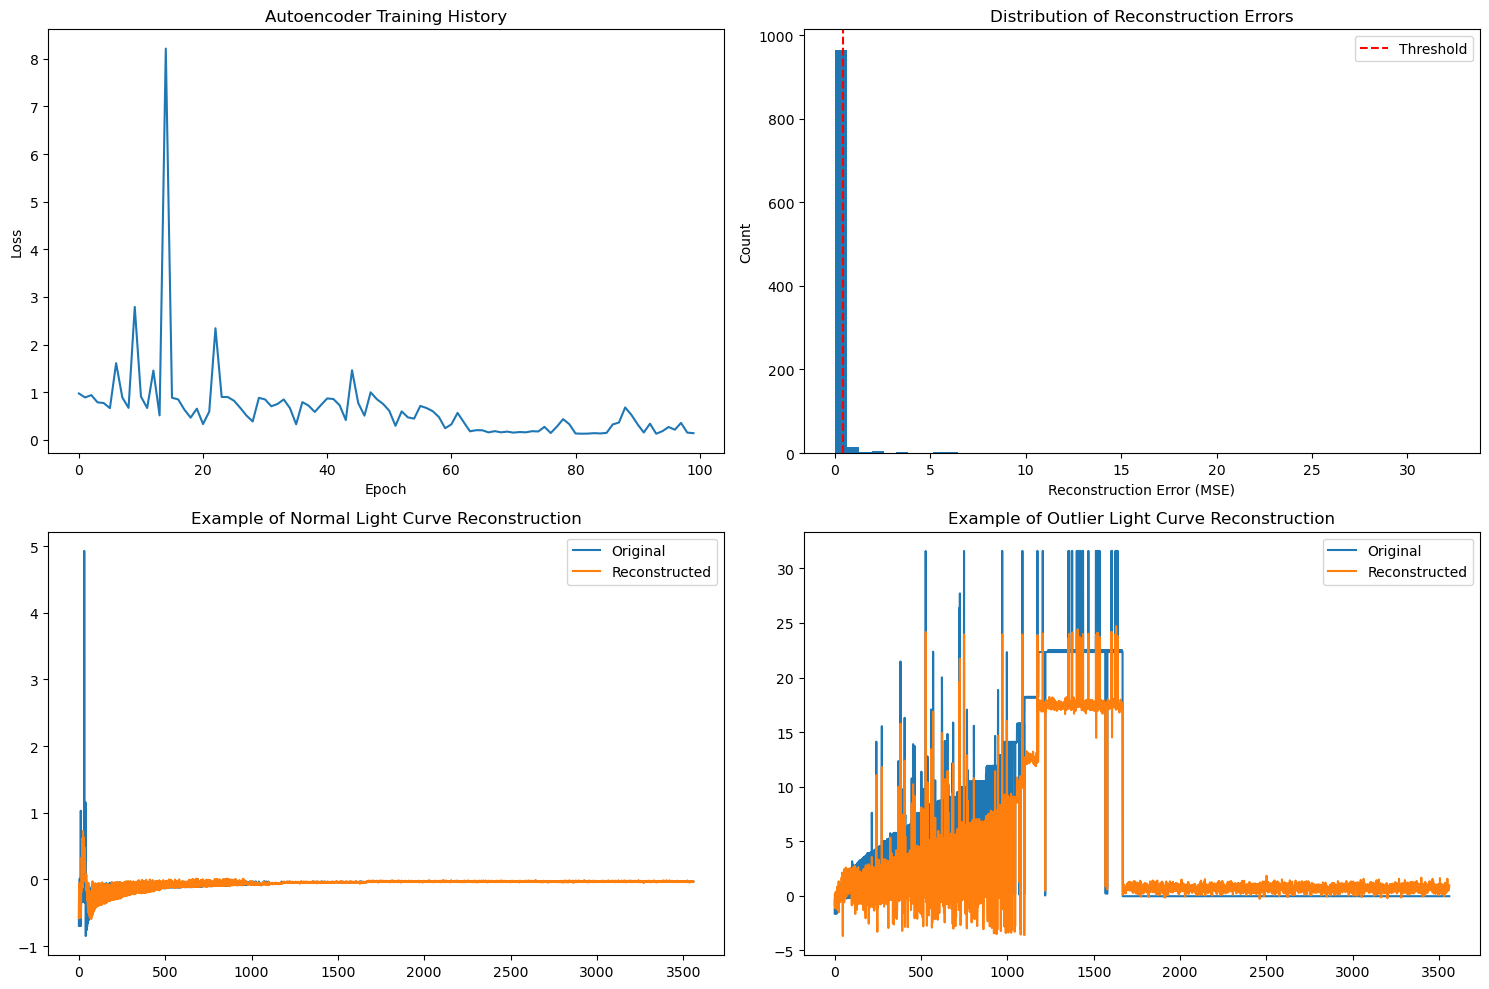

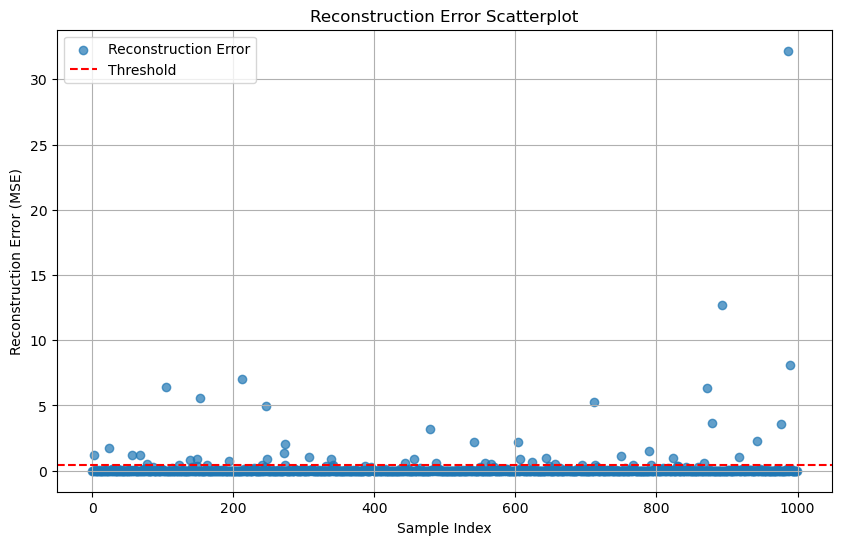


Outlier Files:
  - em01_093156_020_LightCurve_01855_c010_rebinned.fits (Reconstruction Error: 1.2034)


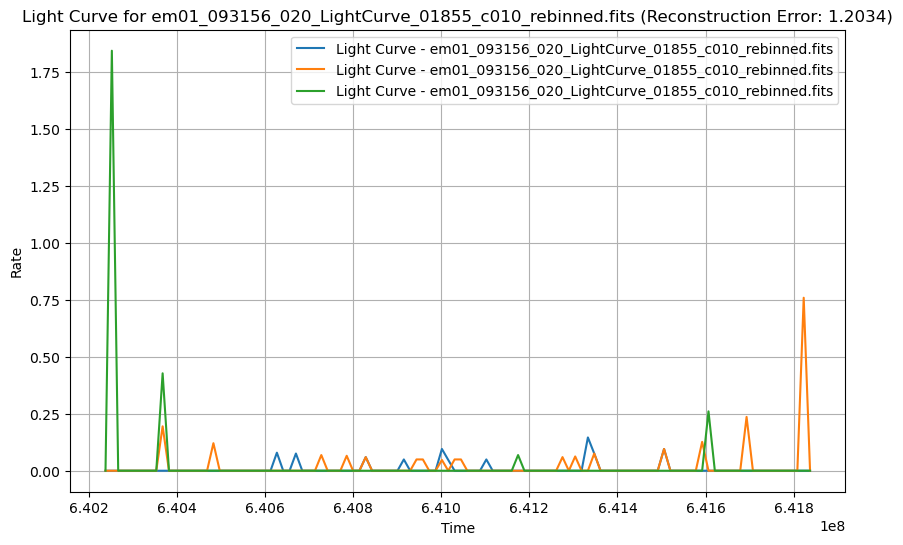

  - em01_085153_020_LightCurve_00446_c010_rebinned.fits (Reconstruction Error: 1.7126)


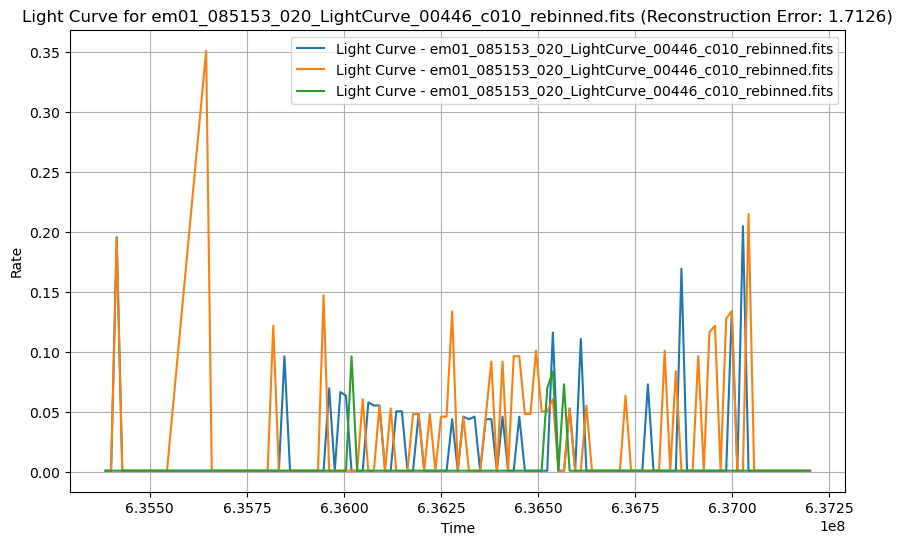

  - em01_098159_020_LightCurve_01251_c010_rebinned.fits (Reconstruction Error: 1.1735)


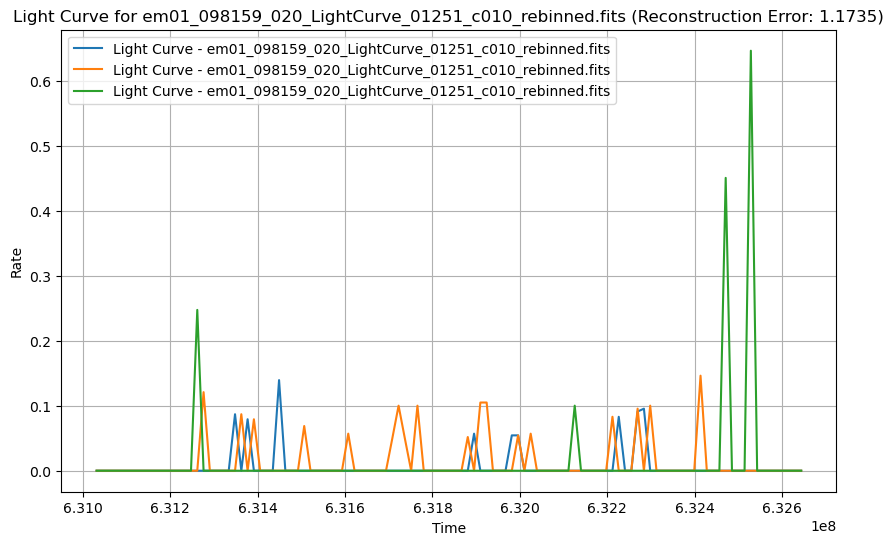

  - em01_106159_020_LightCurve_00091_c010_rebinned.fits (Reconstruction Error: 1.1784)


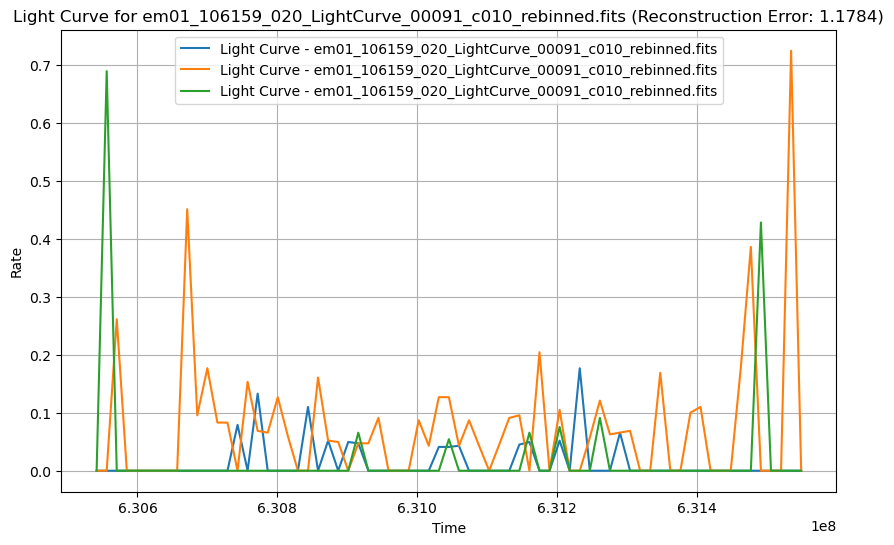

  - em01_113162_020_LightCurve_00088_c010_rebinned.fits (Reconstruction Error: 0.5160)


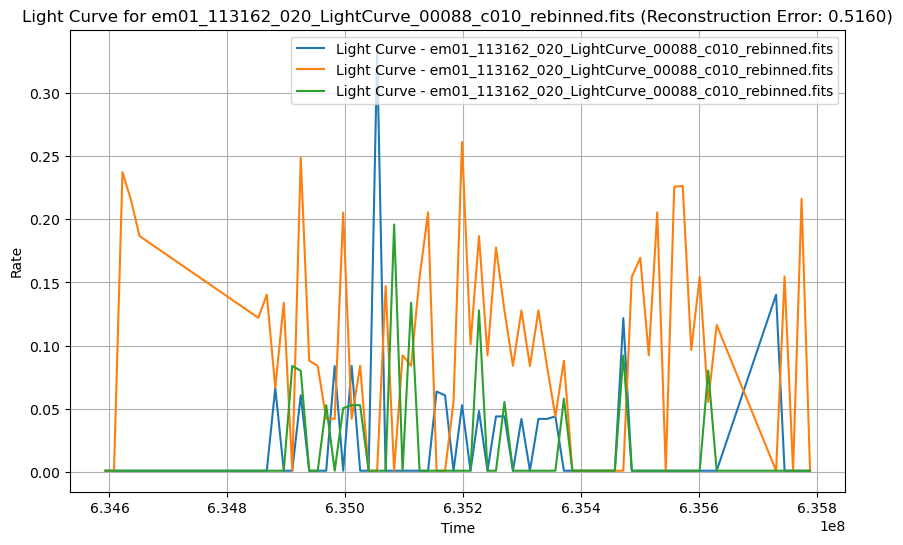

  - em01_093156_020_LightCurve_01332_c010_rebinned.fits (Reconstruction Error: 6.4260)


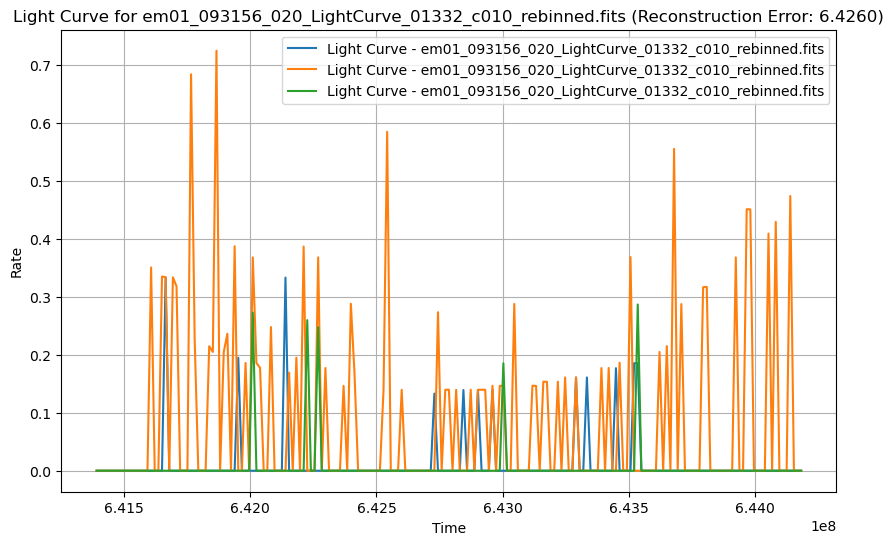

  - en01_265117_020_LightCurve_00003_c010_rebinned.fits (Reconstruction Error: 0.4176)


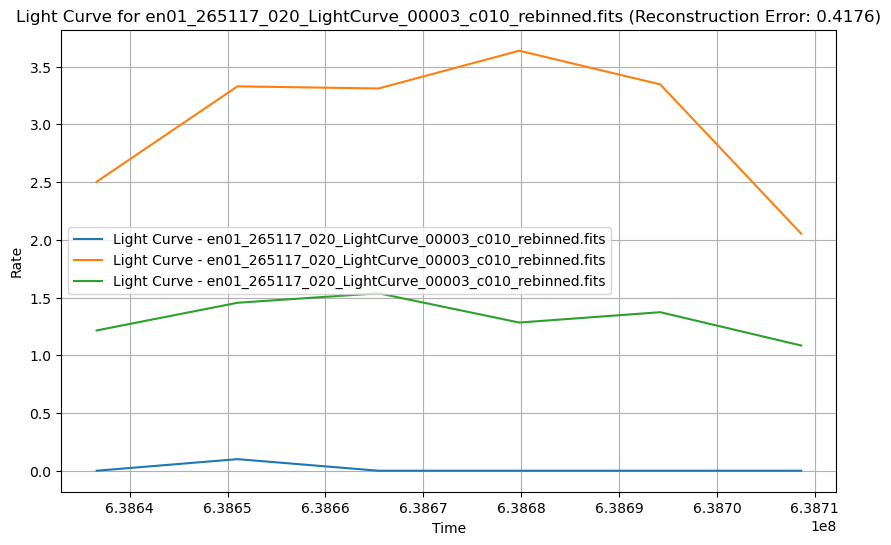

  - em01_090159_020_LightCurve_01808_c010_rebinned.fits (Reconstruction Error: 0.8040)


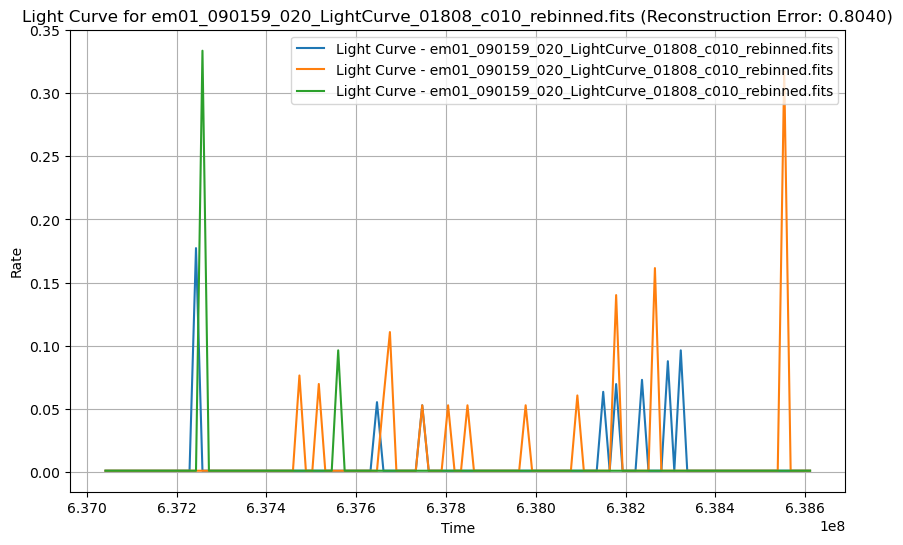

  - em01_106159_020_LightCurve_00110_c010_rebinned.fits (Reconstruction Error: 0.8637)


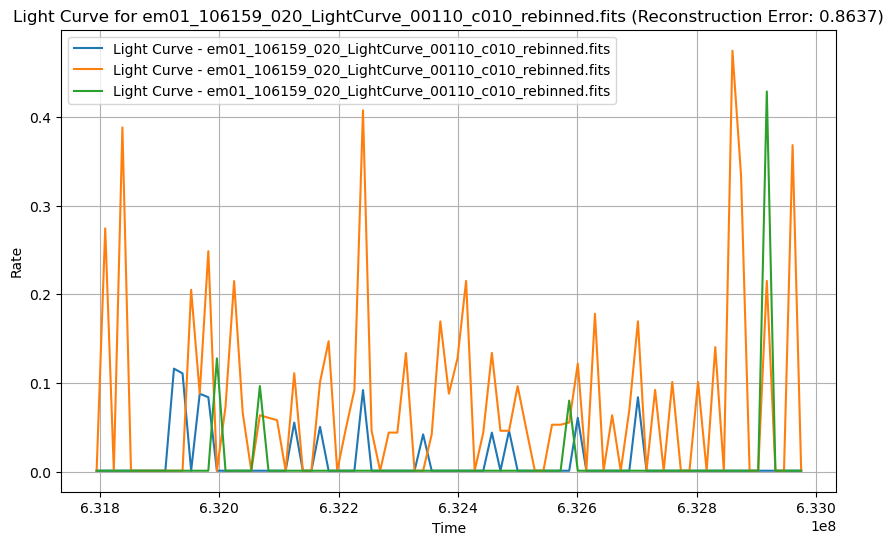

  - em01_098159_020_LightCurve_00022_c010_rebinned.fits (Reconstruction Error: 5.6070)


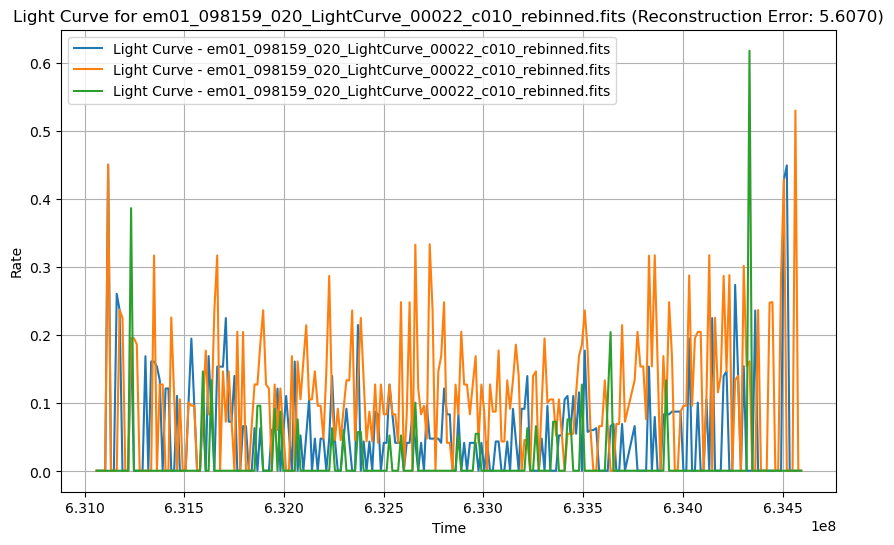

  - em01_053141_020_LightCurve_00060_c010_rebinned.fits (Reconstruction Error: 0.4617)


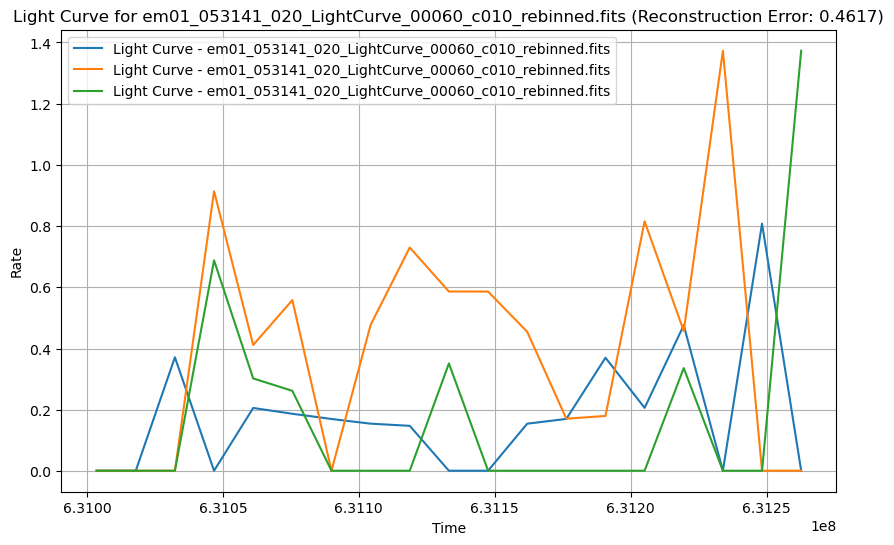

  - em01_098159_020_LightCurve_01485_c010_rebinned.fits (Reconstruction Error: 0.7596)


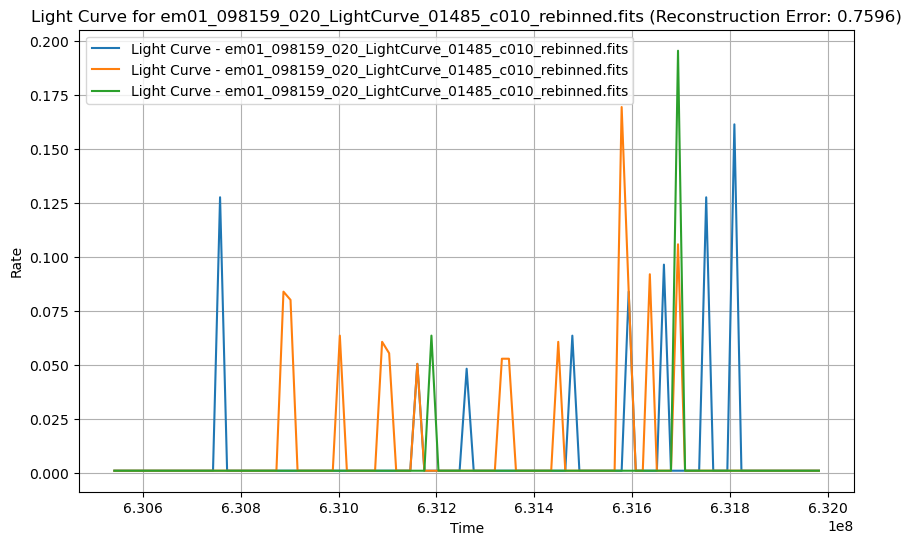

  - em01_093156_020_LightCurve_00927_c010_rebinned.fits (Reconstruction Error: 7.0686)


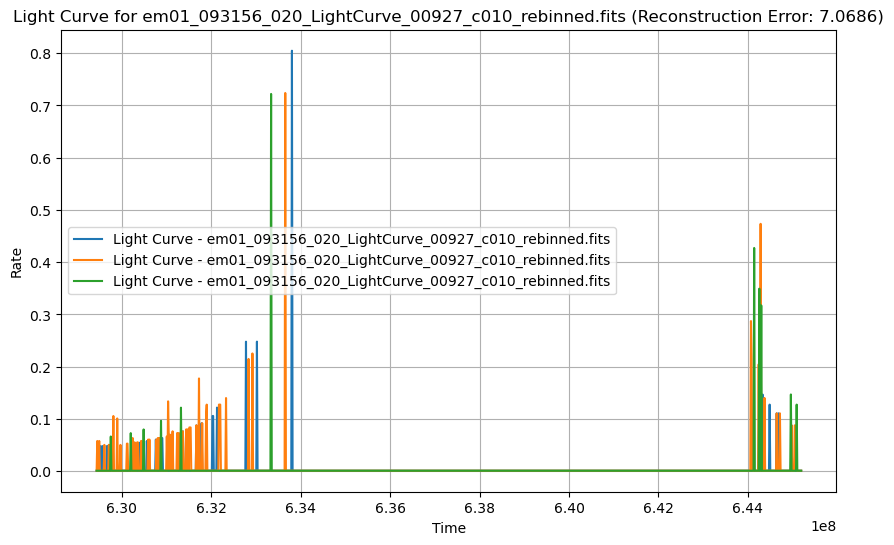

  - em01_092153_020_LightCurve_00950_c010_rebinned.fits (Reconstruction Error: 0.4213)


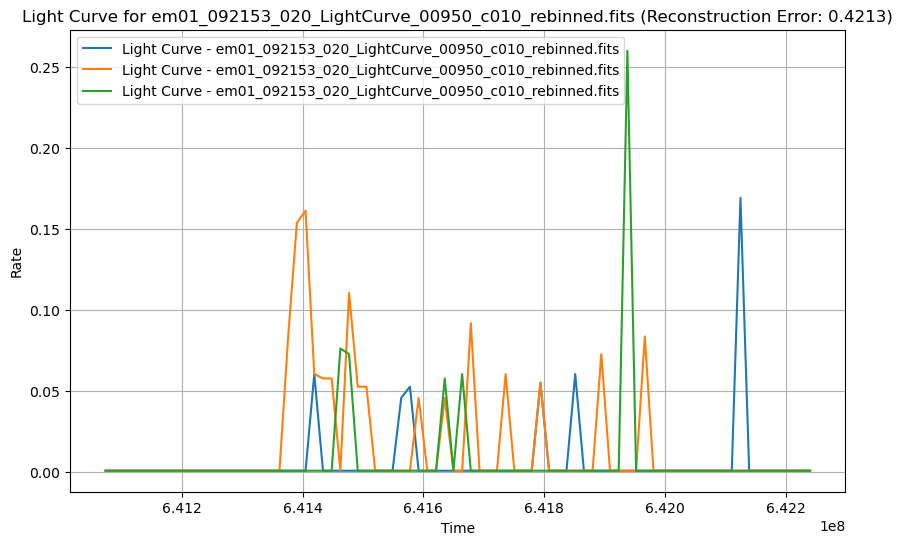

  - em01_093156_020_LightCurve_02672_c010_rebinned.fits (Reconstruction Error: 4.9635)


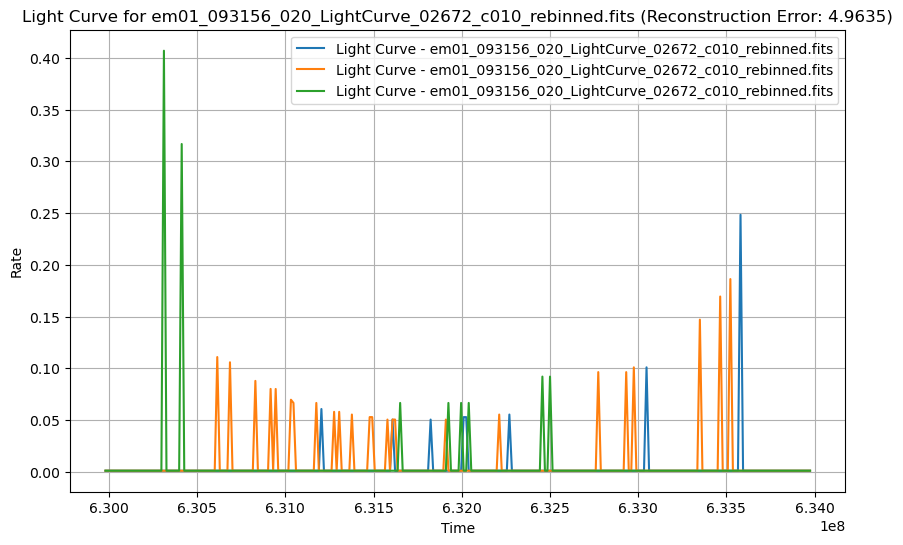

  - em01_113162_020_LightCurve_00338_c010_rebinned.fits (Reconstruction Error: 0.9089)


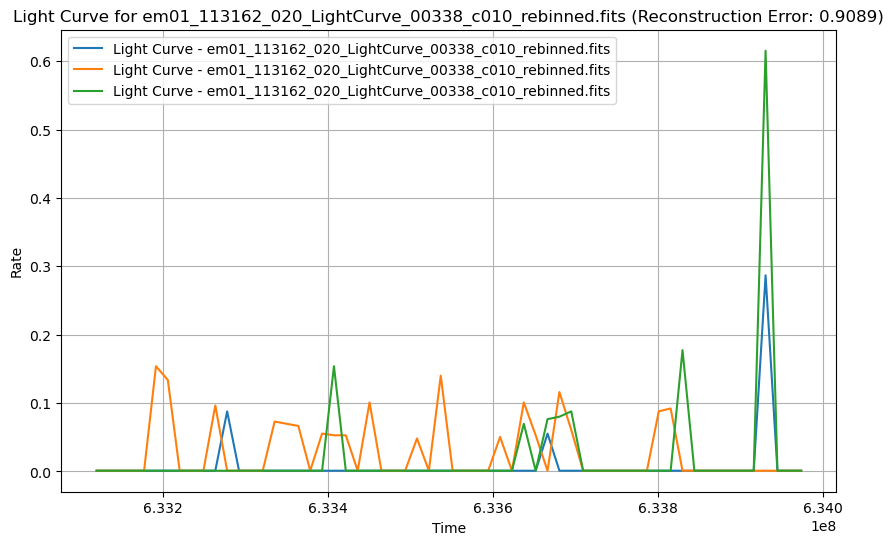

  - em01_100156_020_LightCurve_00444_c010_rebinned.fits (Reconstruction Error: 1.3347)


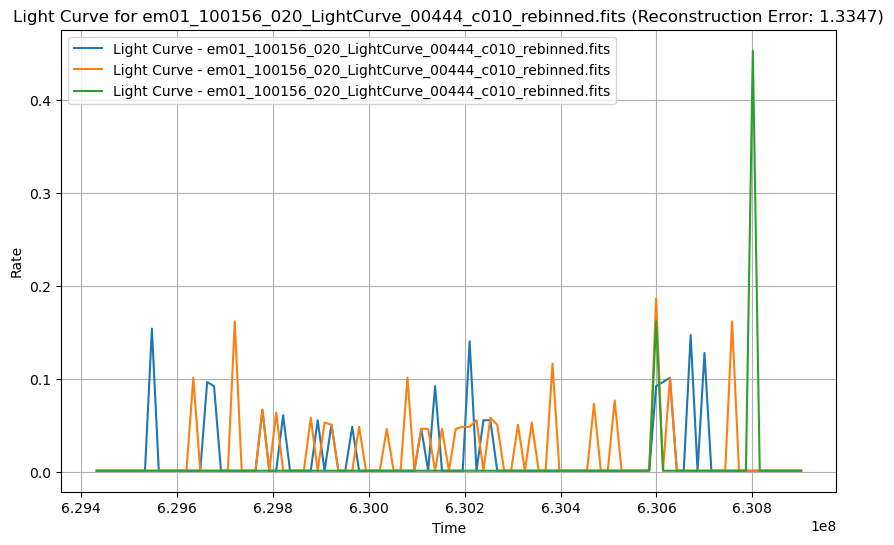

  - em01_079153_020_LightCurve_01690_c010_rebinned.fits (Reconstruction Error: 0.4350)


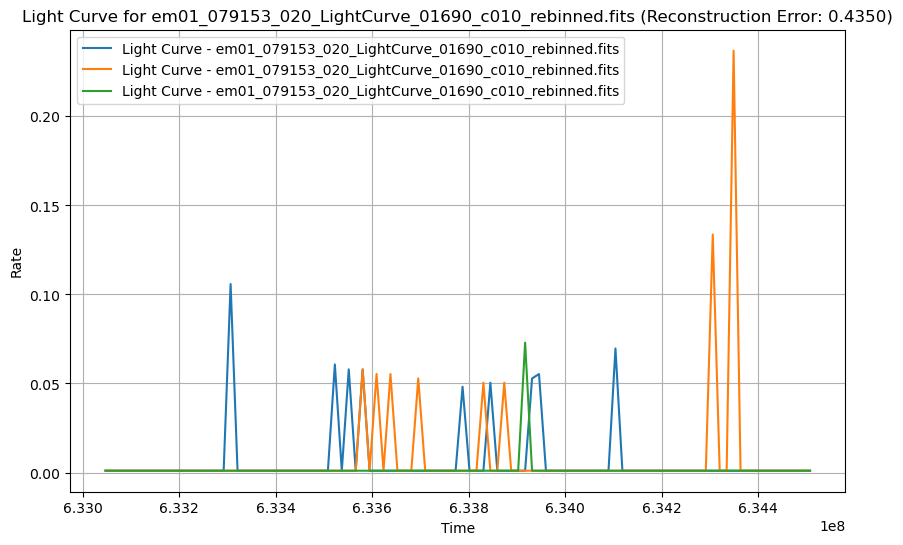

  - em01_082159_020_LightCurve_00133_c010_rebinned.fits (Reconstruction Error: 2.0764)


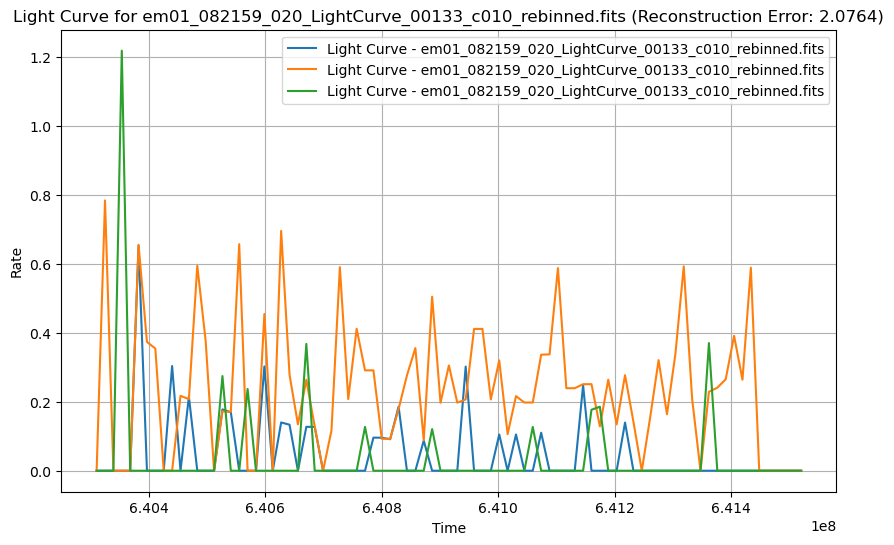

  - em01_104162_020_LightCurve_00324_c010_rebinned.fits (Reconstruction Error: 1.0261)


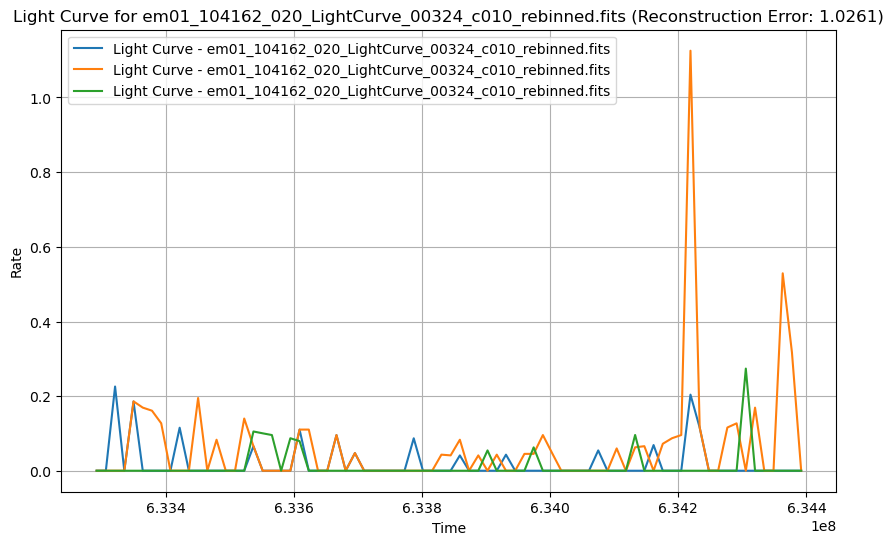

  - em01_083150_020_LightCurve_00035_c010_rebinned.fits (Reconstruction Error: 0.8793)


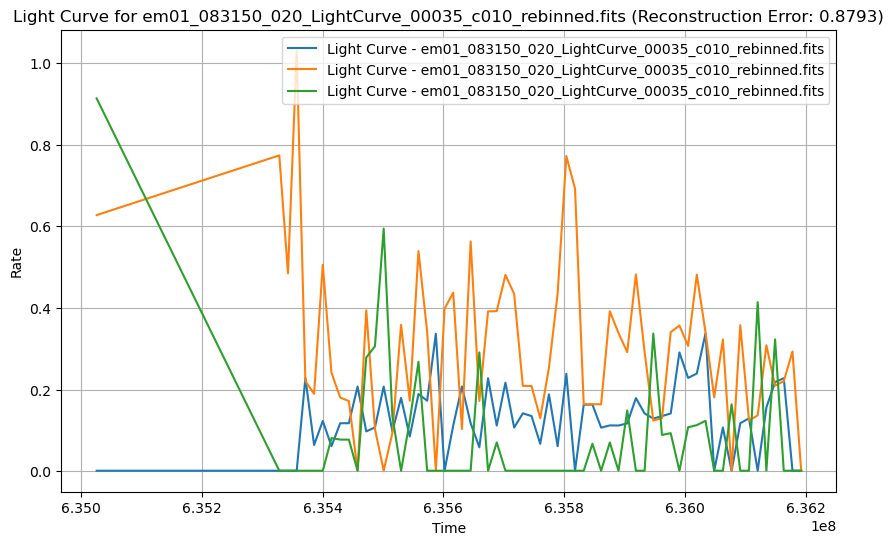

  - em01_085153_020_LightCurve_01220_c010_rebinned.fits (Reconstruction Error: 0.4483)


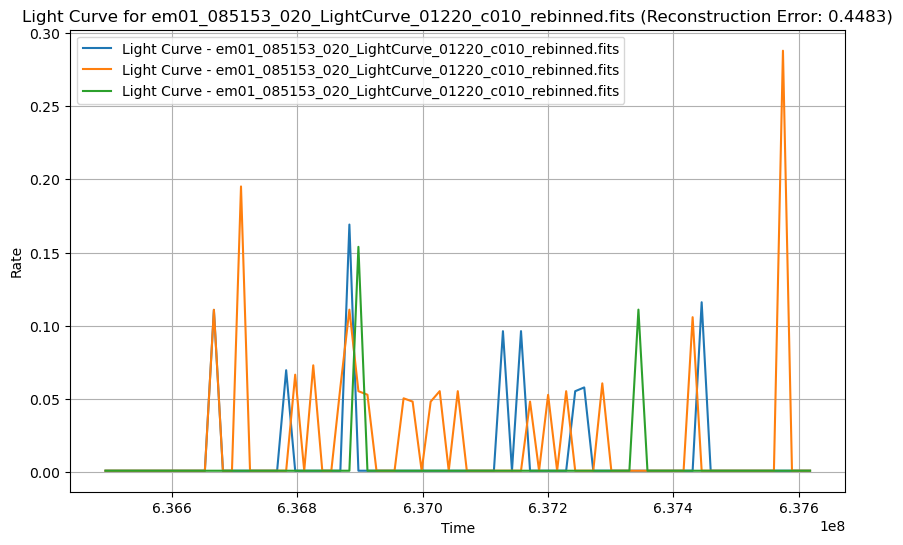

  - em01_113162_020_LightCurve_00042_c010_rebinned.fits (Reconstruction Error: 0.5672)


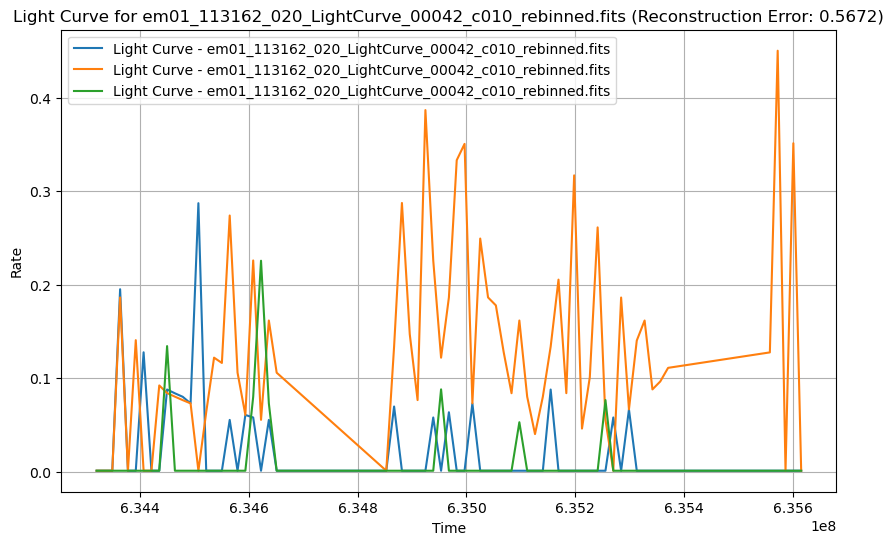

  - em01_083150_020_LightCurve_00113_c010_rebinned.fits (Reconstruction Error: 0.8999)


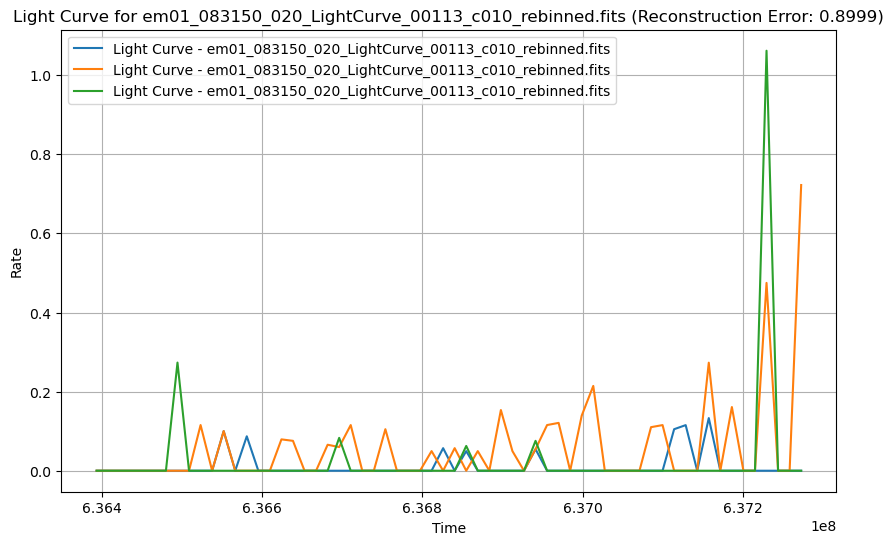

  - em01_079153_020_LightCurve_00107_c010_rebinned.fits (Reconstruction Error: 3.1653)


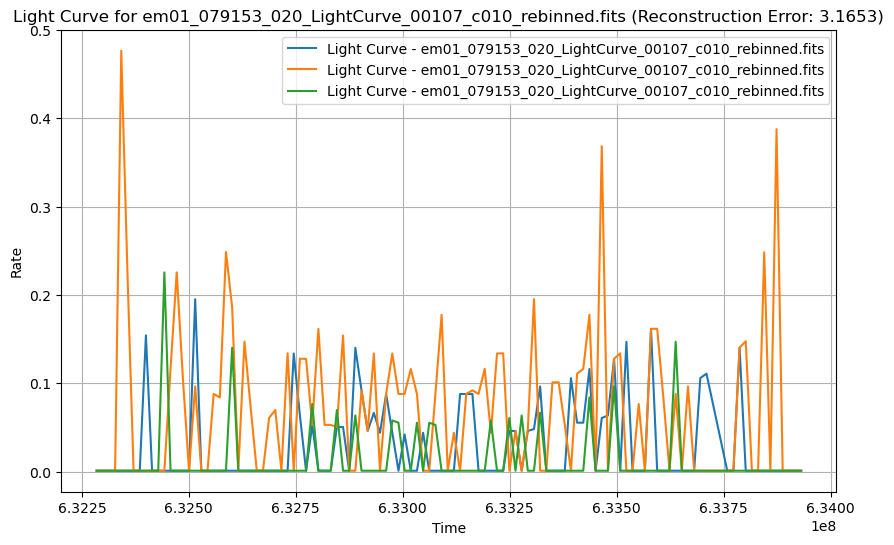

  - em01_073156_020_LightCurve_00339_c010_rebinned.fits (Reconstruction Error: 0.6032)


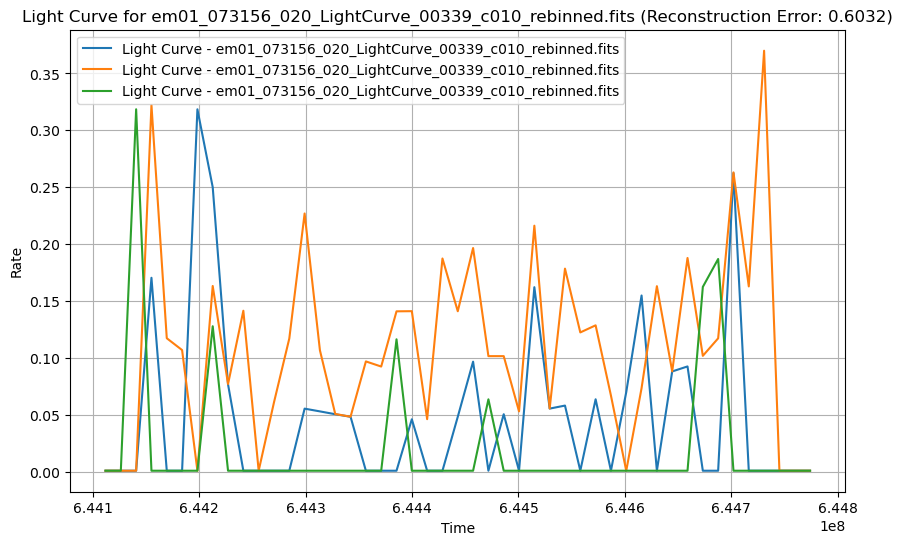

  - em01_098159_020_LightCurve_00980_c010_rebinned.fits (Reconstruction Error: 2.2250)


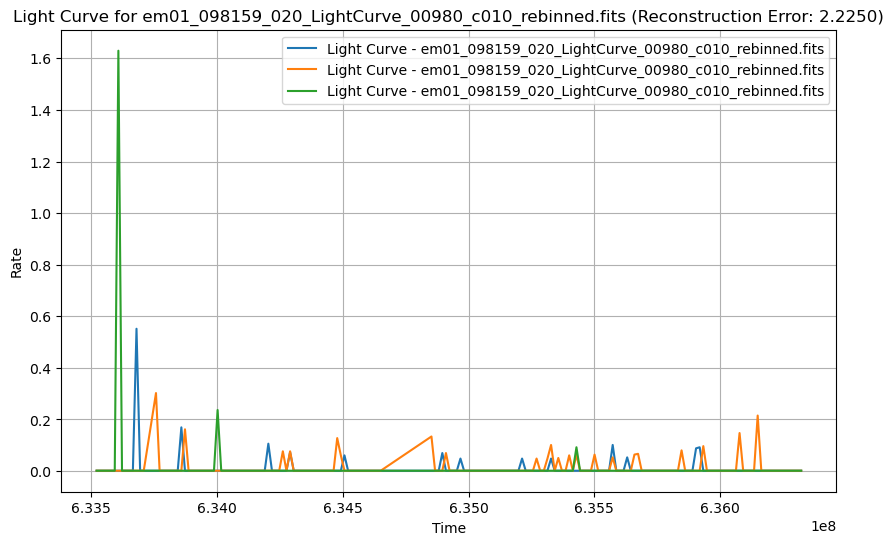

  - em01_080156_020_LightCurve_00605_c010_rebinned.fits (Reconstruction Error: 0.5645)


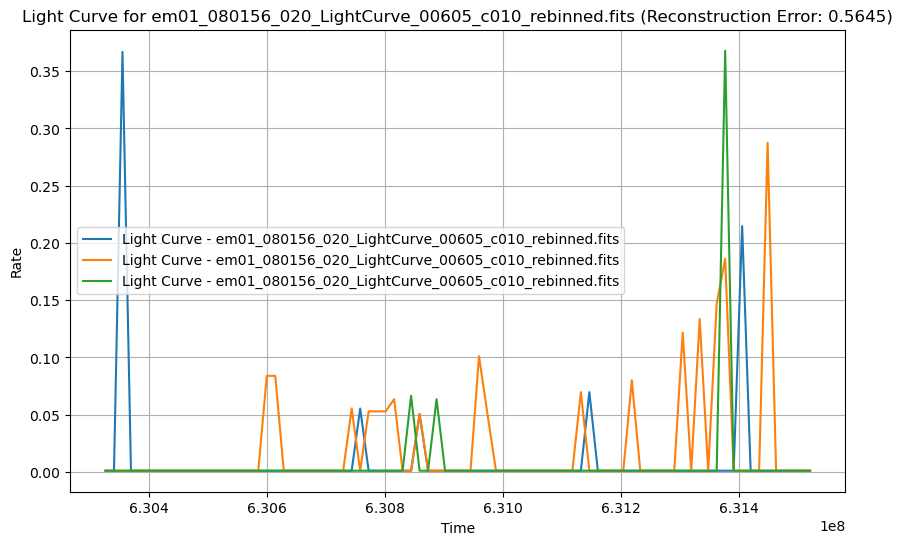

  - em01_106159_020_LightCurve_00667_c010_rebinned.fits (Reconstruction Error: 0.5035)


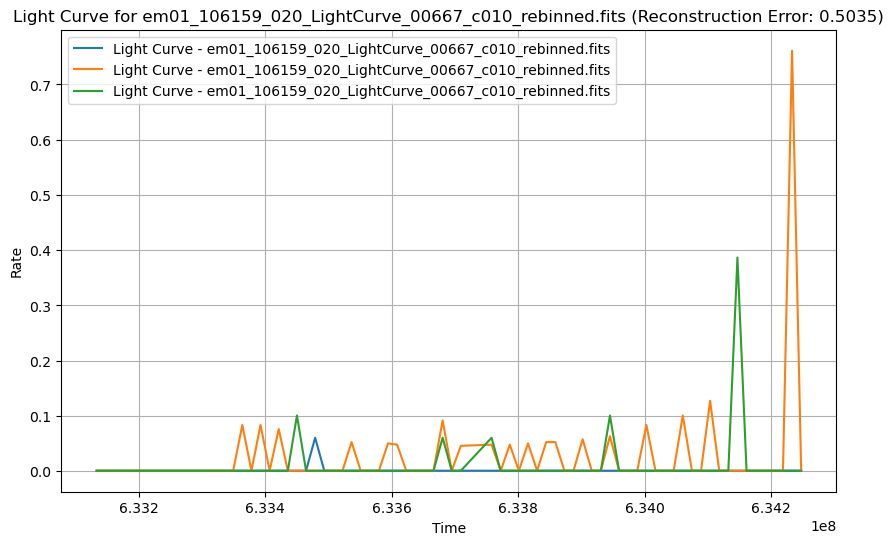

  - em01_098159_020_LightCurve_00674_c010_rebinned.fits (Reconstruction Error: 2.2130)


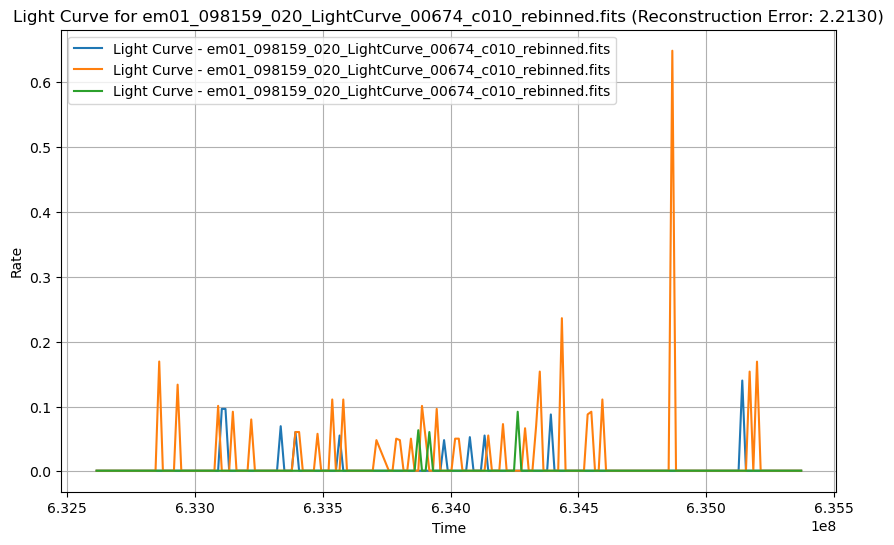

  - em01_085153_020_LightCurve_00985_c010_rebinned.fits (Reconstruction Error: 0.8667)


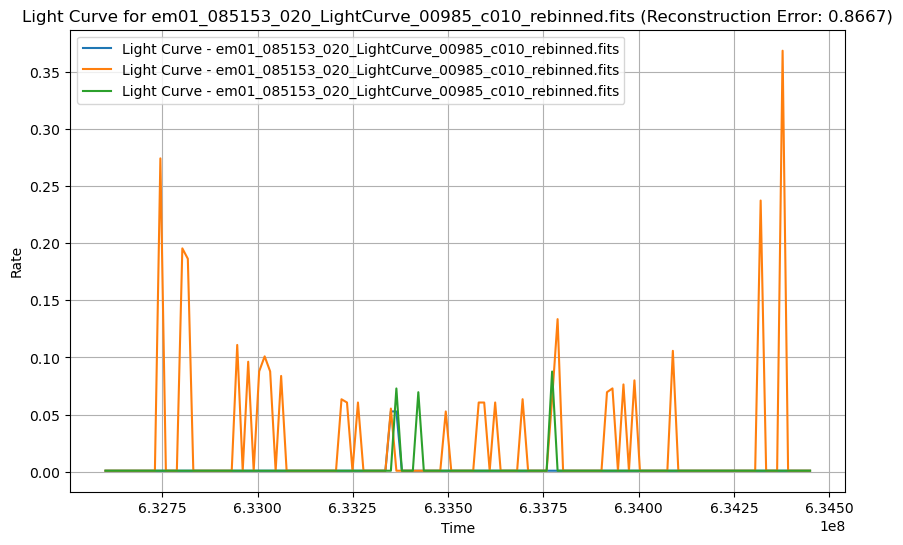

  - em01_089150_020_LightCurve_00300_c010_rebinned.fits (Reconstruction Error: 0.6384)


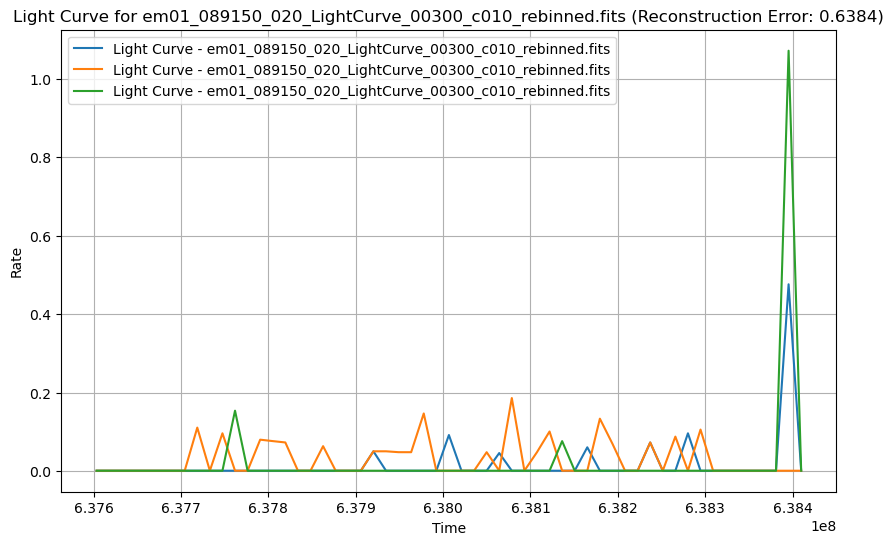

  - em01_082159_020_LightCurve_00476_c010_rebinned.fits (Reconstruction Error: 0.9827)


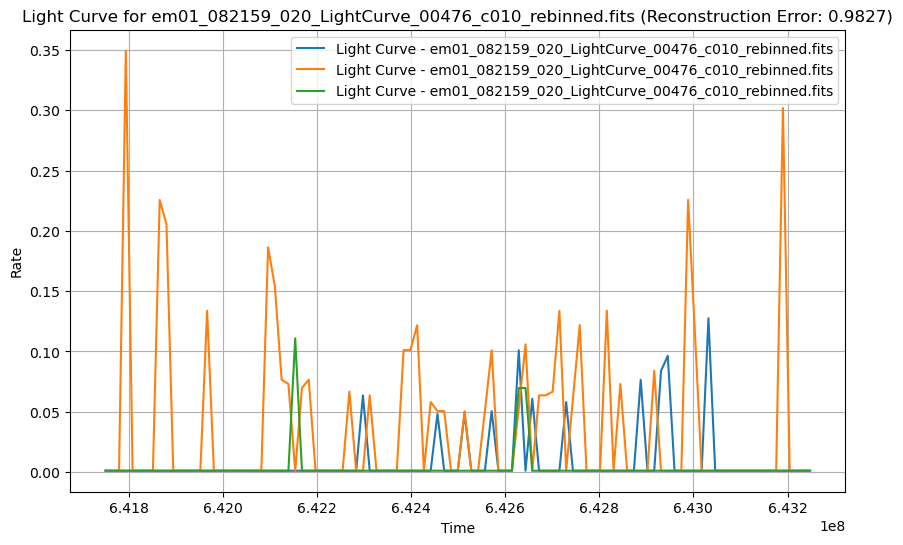

  - em01_089084_020_LightCurve_00001_c010_rebinned.fits (Reconstruction Error: 0.5453)


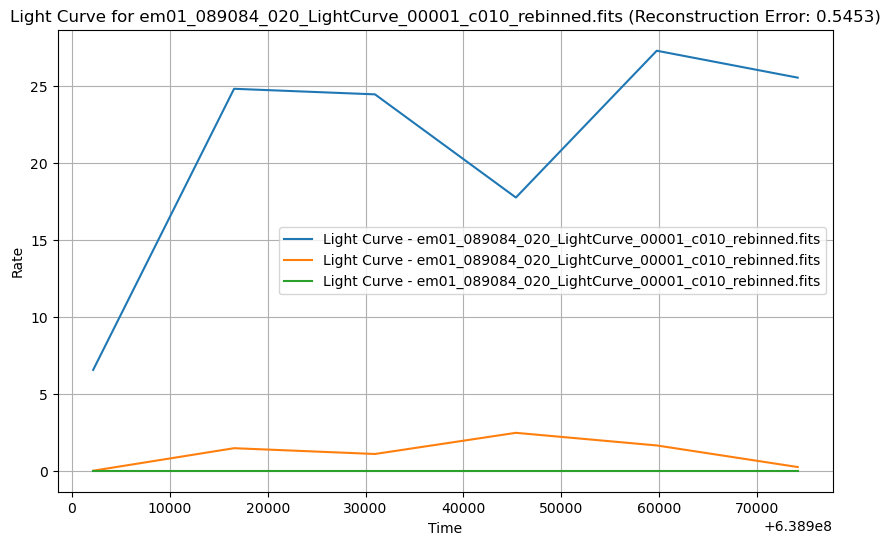

  - em01_071150_020_LightCurve_00371_c010_rebinned.fits (Reconstruction Error: 0.4459)


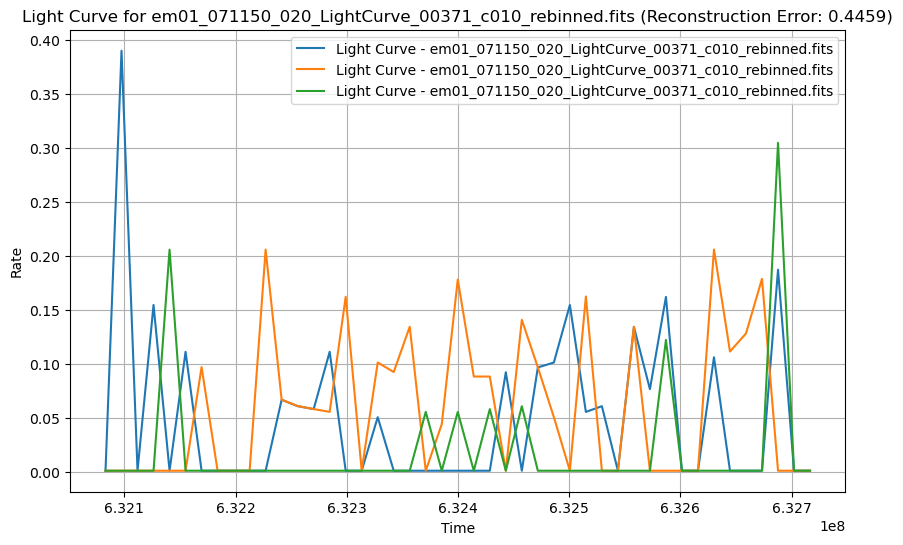

  - em01_087156_020_LightCurve_00442_c010_rebinned.fits (Reconstruction Error: 5.2902)


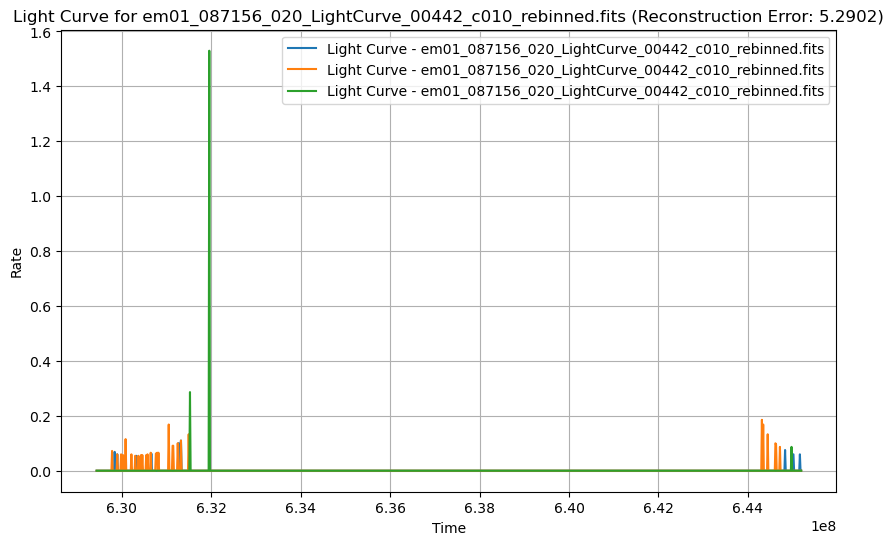

  - em01_106159_020_LightCurve_00626_c010_rebinned.fits (Reconstruction Error: 1.1294)


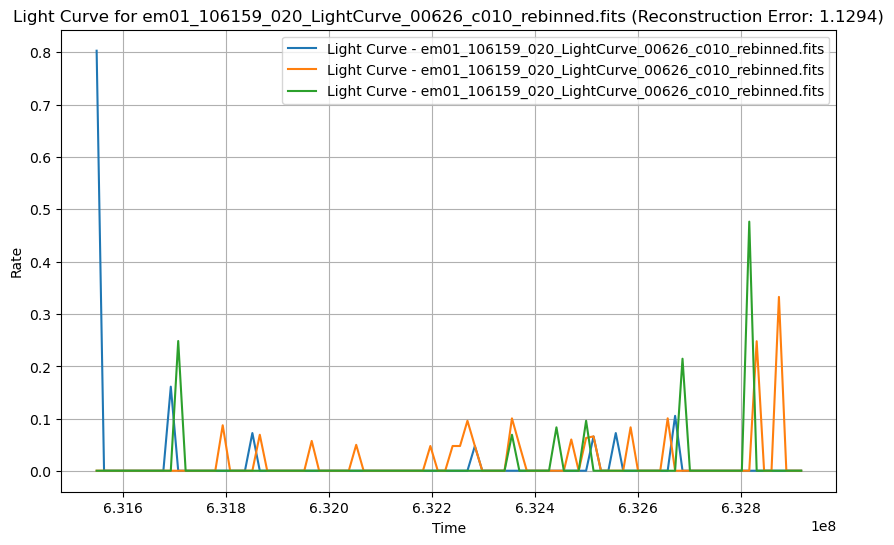

  - em01_076141_020_LightCurve_00102_c010_rebinned.fits (Reconstruction Error: 0.4202)


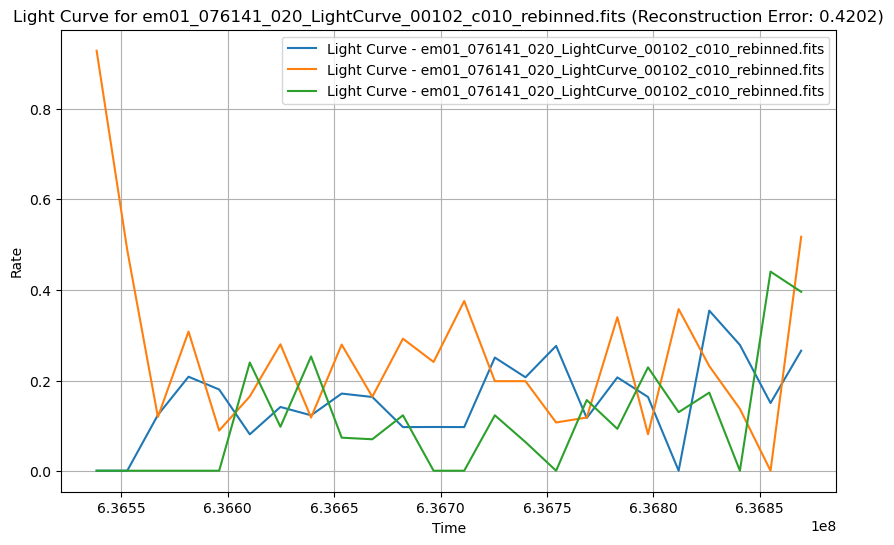

  - em01_093156_020_LightCurve_02366_c010_rebinned.fits (Reconstruction Error: 1.4922)


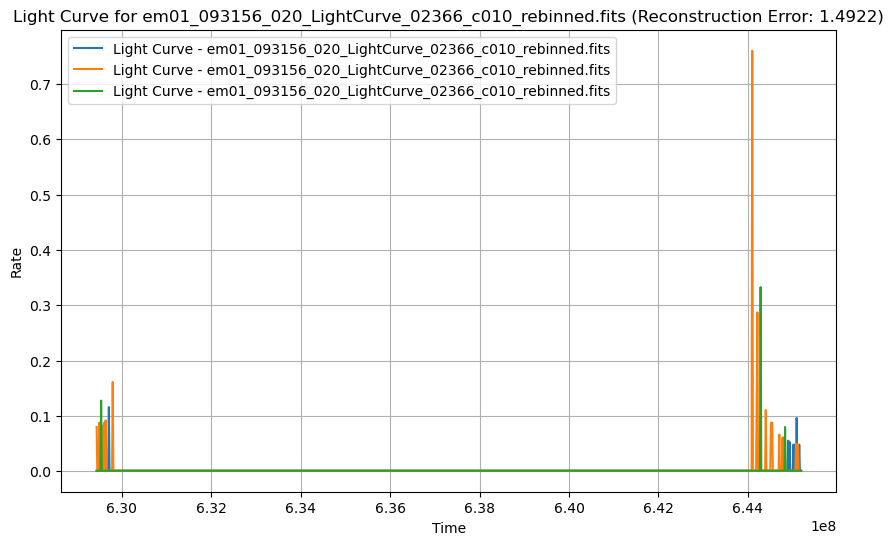

  - em01_094150_020_LightCurve_00211_c010_rebinned.fits (Reconstruction Error: 0.4384)


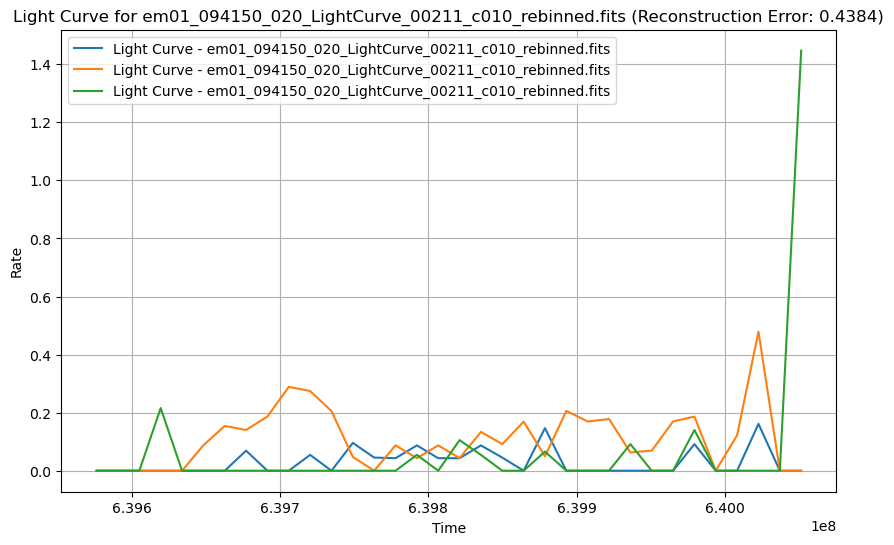

  - em01_090159_020_LightCurve_01214_c010_rebinned.fits (Reconstruction Error: 0.9834)


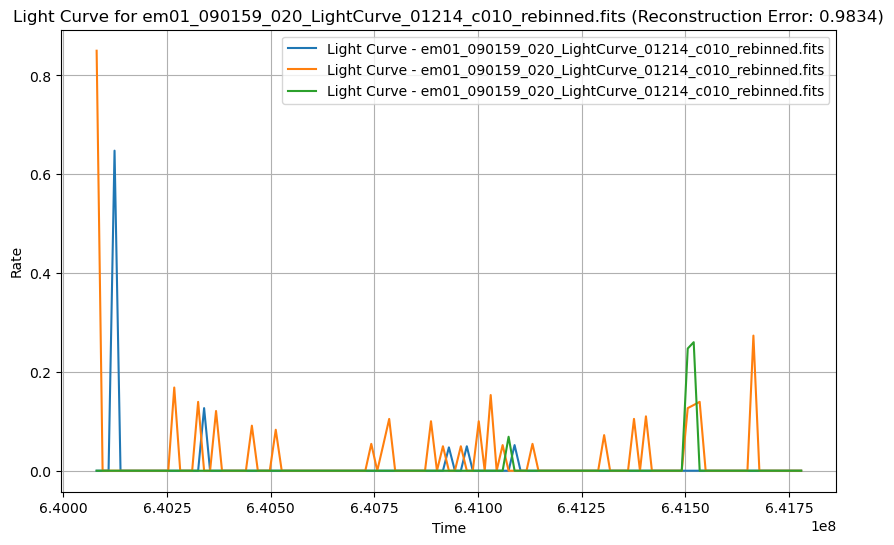

  - em01_085153_020_LightCurve_01341_c010_rebinned.fits (Reconstruction Error: 0.6042)


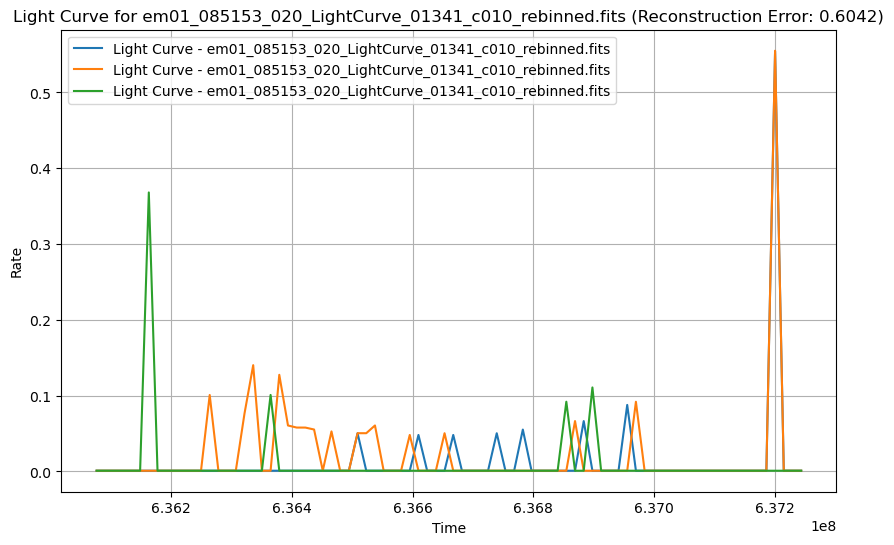

  - em01_090159_020_LightCurve_00262_c010_rebinned.fits (Reconstruction Error: 6.3707)


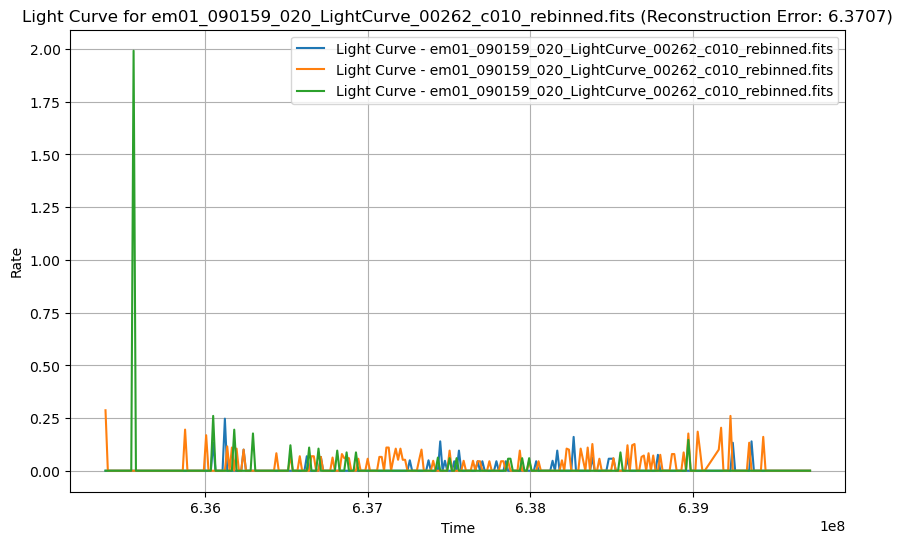

  - em01_093156_020_LightCurve_00405_c010_rebinned.fits (Reconstruction Error: 3.6306)


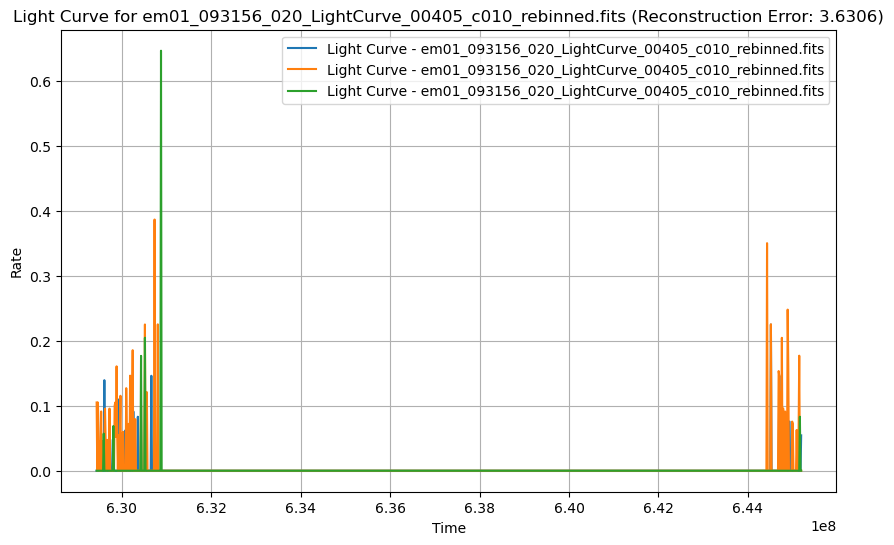

  - em01_087156_020_LightCurve_00125_c010_rebinned.fits (Reconstruction Error: 12.6881)


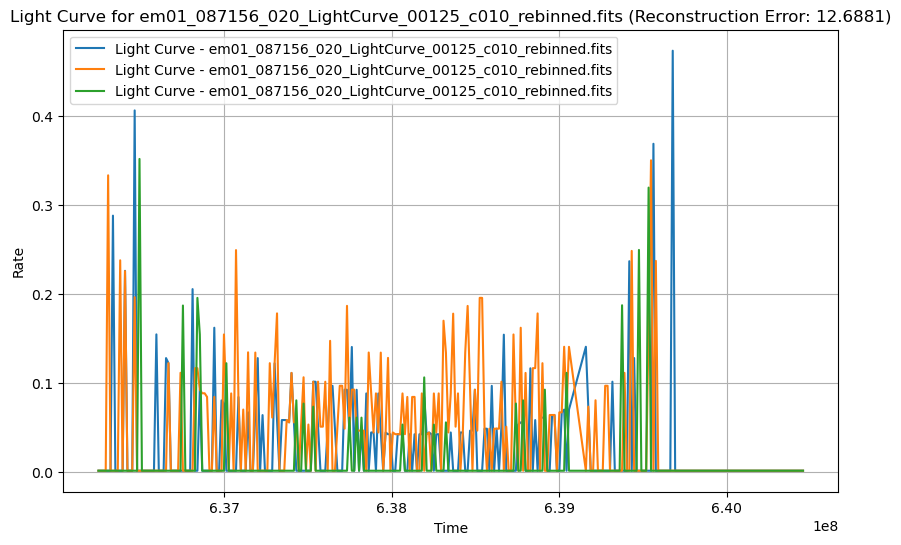

  - em01_085153_020_LightCurve_01253_c010_rebinned.fits (Reconstruction Error: 1.0447)


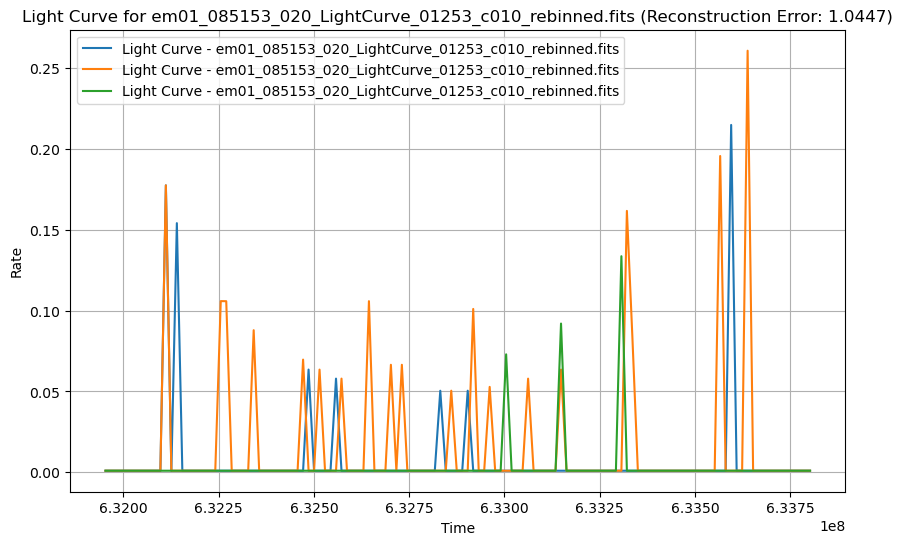

  - em01_087156_020_LightCurve_01710_c010_rebinned.fits (Reconstruction Error: 2.3066)


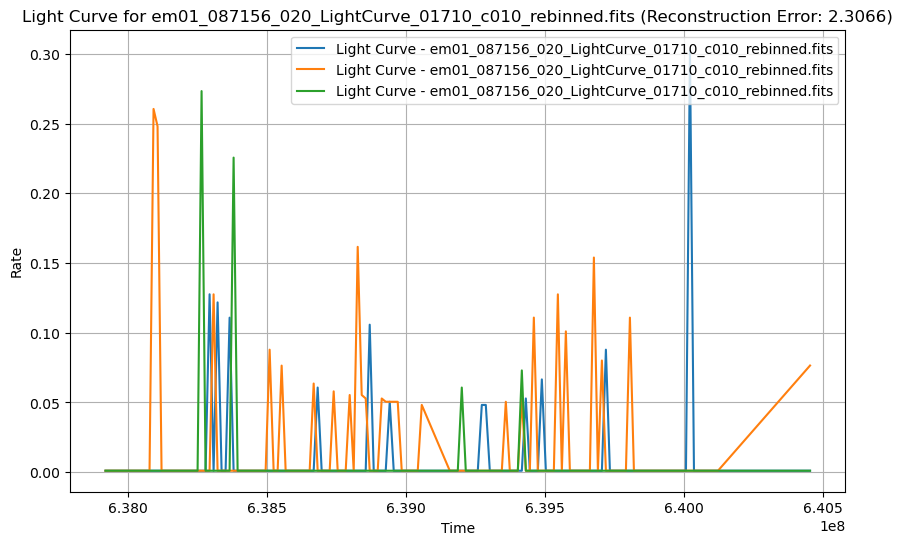

  - em01_090159_020_LightCurve_00146_c010_rebinned.fits (Reconstruction Error: 3.5953)


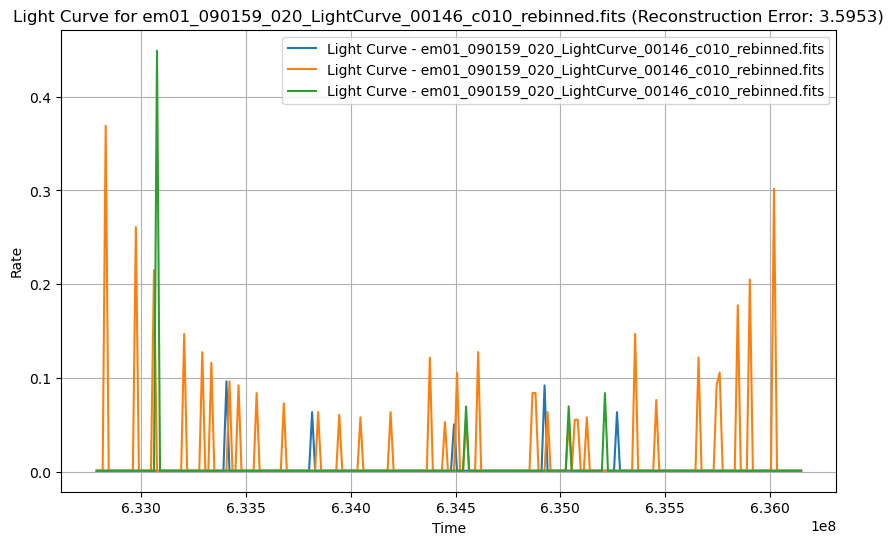

  - em01_087156_020_LightCurve_02533_c010_rebinned.fits (Reconstruction Error: 32.1907)


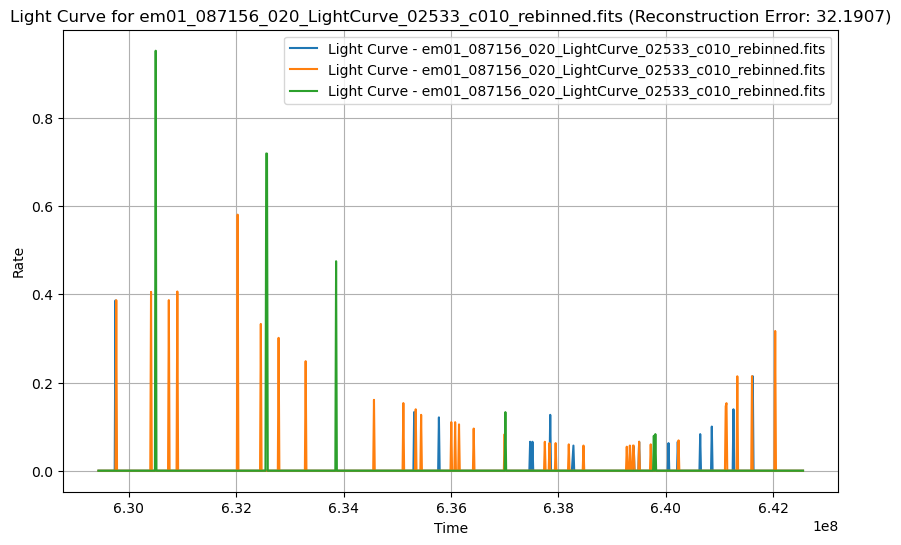

  - em01_093156_020_LightCurve_00311_c010_rebinned.fits (Reconstruction Error: 8.0682)


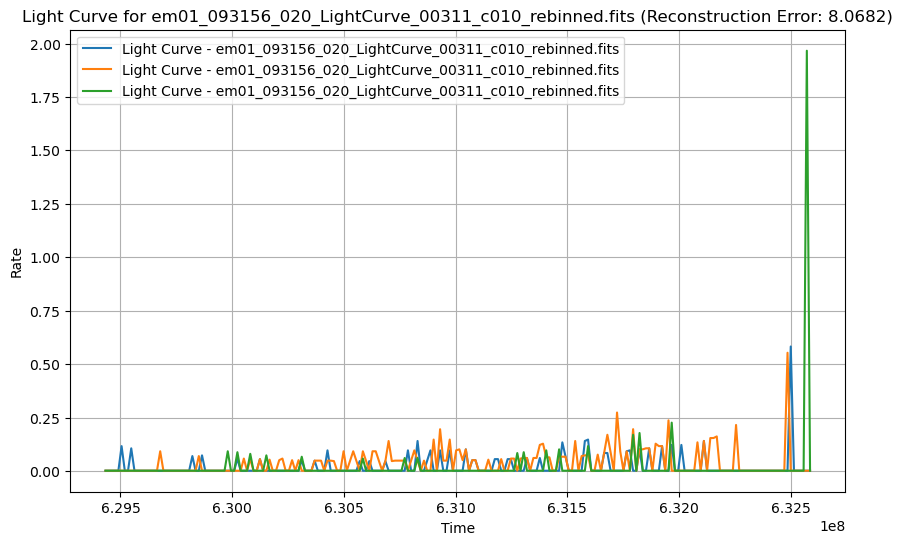

In [1]:
import os
import numpy as np
from astropy.io import fits
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#this is the directory that we are taking the FITs files from
fits_dir = r'/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'

# sampling random set of 1000 FITs files
fits_files = [f for f in os.listdir(fits_dir) if f.endswith('.fits')] #this is to make sure we're only sampling from fits files
fits_files_sample = np.random.choice(fits_files, size = 1000, replace=False)



# Extract data from FITS files
light_curves = [] #list to store extracted light curve data, including time and rate, from each FITs file
file_names = [] #list to store the names of the files that we are extracting data from

for file in fits_files_sample:
    file_path = os.path.join(fits_dir, file) #this is just to create the full path to the FITs file
    with fits.open(file_path) as hdul:
        if 'RATE' in hdul and len(hdul['RATE'].data) > 0: #just to make sure that there's actually a data table containing RATE
            time = hdul['RATE'].data['TIME'] 
            rate = hdul['RATE'].data['RATE']
            light_curves.append(np.column_stack((time, rate)))
            file_names.append(file)

# Flatten and preprocess data
flattened_data = [lc.flatten() for lc in light_curves if lc is not None]
data_matrix = np.array([np.pad(fd, (0, max(map(len, flattened_data)) - len(fd)), 'constant') 
                       for fd in flattened_data])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_matrix)

# Convert to PyTorch tensors
data_tensor = torch.FloatTensor(data_scaled)
dataset = TensorDataset(data_tensor, data_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model
input_dim = data_scaled.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
n_epochs = 100
train_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_features, _ in dataloader:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    epoch_loss = epoch_loss / len(dataloader)
    train_losses.append(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')

# Evaluate reconstruction error
model.eval()
with torch.no_grad():
    reconstructed = model(data_tensor)
    mse = torch.mean((data_tensor - reconstructed) ** 2, dim=1).numpy()

# Define threshold for outlier detection (95th percentile)
threshold = np.percentile(mse, 95)
outliers = mse > threshold

# Plot results
plt.figure(figsize=(15, 10))

# Plot training history
plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training History')

# Plot reconstruction error distribution
plt.subplot(2, 2, 2)
plt.hist(mse, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Reconstruction Errors')

# Plot example reconstructions
plt.subplot(2, 2, 3)
example_idx = np.random.choice(np.where(~outliers)[0])
plt.plot(data_scaled[example_idx], label='Original')
plt.plot(reconstructed[example_idx].numpy(), label='Reconstructed')
plt.title('Example of Normal Light Curve Reconstruction')
plt.legend()

# Plot example outlier reconstruction
plt.subplot(2, 2, 4)
if np.any(outliers):
    outlier_idx = np.random.choice(np.where(outliers)[0])
    plt.plot(data_scaled[outlier_idx], label='Original')
    plt.plot(reconstructed[outlier_idx].numpy(), label='Reconstructed')
    plt.title('Example of Outlier Light Curve Reconstruction')
    plt.legend()

plt.tight_layout()
plt.show()

# Scatterplot of reconstruction errors vs indices
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mse)), mse, alpha=0.7, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error Scatterplot')
plt.legend()
plt.grid(True)
plt.show()

# Scatterplot of original vs reconstructed example (normal)
#plt.figure(figsize=(10, 6))
#plt.scatter(data_scaled[example_idx], reconstructed[example_idx].numpy(), alpha=0.7)
#plt.xlabel('Original Values')
#plt.ylabel('Reconstructed Values')
#plt.title('Scatterplot of Original vs Reconstructed (Normal Example)')
#plt.grid(True)
#plt.show()

# Scatterplot of original vs reconstructed example (outlier)
#if np.any(outliers):
#    plt.figure(figsize=(10, 6))
#    plt.scatter(data_scaled[outlier_idx], reconstructed[outlier_idx].numpy(), alpha=0.7, color='orange')
#    plt.xlabel('Original Values')
#    plt.ylabel('Reconstructed Values')
#    plt.title('Scatterplot of Original vs Reconstructed (Outlier Example)')
#    plt.grid(True)
#    plt.show()

# Print outlier files and plot their light curves
print("\nOutlier Files:")
for idx, is_outlier in enumerate(outliers):
    if is_outlier:
        print(f"  - {file_names[idx]} (Reconstruction Error: {mse[idx]:.4f})")
        # Plot the outlier light curve
        file_path = os.path.join(fits_dir, file_names[idx])
        with fits.open(file_path) as hdul:
            if 'RATE' in hdul:
                time = hdul['RATE'].data['TIME']
                rate = hdul['RATE'].data['RATE']
                plt.figure(figsize=(10, 6))
                plt.plot(time, rate, label=f"Light Curve - {file_names[idx]}")
                plt.xlabel('Time')
                plt.ylabel('Rate')
                plt.title(f'Light Curve for {file_names[idx]} (Reconstruction Error: {mse[idx]:.4f})')
                plt.legend()
                plt.grid(True)
                plt.show()

In [2]:
import os
import numpy as np
from astropy.io import fits
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#this is the directory that we are taking the FITs files from
fits_dir = r'/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'

# sampling random set of 1000 FITs files
fits_files = [f for f in os.listdir(fits_dir) if f.endswith('.fits')] #this is to make sure we're only sampling from fits files
fits_files_sample = np.random.choice(fits_files, size = 1000, replace=False)



# Extract data from FITS files
light_curves = [] #list to store extracted light curve data, including time and rate, from each FITs file
file_names = [] #list to store the names of the files that we are extracting data from

for file in fits_files_sample:
    file_path = os.path.join(fits_dir, file) #this is just to create the full path to the FITs file
    with fits.open(file_path) as hdul:
        if 'RATE' in hdul and len(hdul['RATE'].data) > 0: #just to make sure that there's actually a data table containing RATE
            time = hdul['RATE'].data['TIME'] 
            rate = hdul['RATE'].data['RATE']
            light_curves.append(np.column_stack((time, rate)))
            file_names.append(file)
            
print(light_curves)
            
# Flatten and preprocess data
#flattened_data = [lc.flatten() for lc in light_curves if lc is not None]
#data_matrix = np.array([np.pad(fd, (0, max(map(len, flattened_data)) - len(fd)), 'constant') 
#                       for fd in flattened_data])

[array([[6.33912936e+08, 1.00000005e-03, 1.00000005e-03, 1.00000005e-03],
       [6.33927336e+08, 7.64340982e-02, 2.25863814e-01, 1.00000005e-03],
       [6.33941736e+08, 1.00000005e-03, 5.28964028e-02, 1.00000005e-03],
       [6.33956136e+08, 1.00000005e-03, 4.40271385e-02, 1.00000005e-03],
       [6.33970536e+08, 1.00000005e-03, 1.21939935e-01, 1.00000005e-03],
       [6.33984936e+08, 1.00000005e-03, 1.54261068e-01, 1.00000005e-03],
       [6.33999336e+08, 6.35697991e-02, 1.27893090e-01, 1.00000005e-03],
       [6.34013741e+08, 1.00000005e-03, 1.05996110e-01, 1.86484456e-01],
       [6.34028136e+08, 1.00000005e-03, 2.49431431e-01, 1.00000005e-03]]), array([[6.33804324e+08, 1.00000005e-03, 1.00000005e-03, 1.00000005e-03],
       [6.33818719e+08, 1.00000005e-03, 2.61070013e-01, 1.00000005e-03],
       [6.33833124e+08, 1.21663503e-01, 1.00000005e-03, 1.00000005e-03],
       [6.33847519e+08, 1.00000005e-03, 1.00000005e-03, 1.00000005e-03],
       [6.33861919e+08, 4.20031659e-02, 1.275805

In [3]:
from astropy.io import fits
import os

file_path = os.path.join(fits_dir, fits_files_sample[0])  # Replace with a sample file
with fits.open(file_path) as hdul:
    print(hdul['RATE'].columns)

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'TIMEDEL'; format = 'D'; unit = 's'
    name = 'COUNTS'; format = '3J'; unit = 'count'; dim = '(3)'
    name = 'RATE'; format = '3E'; unit = 'count s-1'; dim = '(3)'
    name = 'RATE_ERRM'; format = '3E'; unit = 'count s-1'; dim = '(3)'
    name = 'RATE_ERRP'; format = '3E'; unit = 'count s-1'; dim = '(3)'
    name = 'BACK_COUNTS'; format = '3E'; unit = 'count'; dim = '(3)'
    name = 'FRACEXP'; format = '3E'; unit = 'ratio'; dim = '(3)'
    name = 'BACKSCAL_SRC'; format = 'E'; unit = 'deg2'
    name = 'BACKSCAL_BACK'; format = 'E'; unit = 'deg2'
    name = 'BACKRATIO'; format = 'D'; unit = 'ratio'
)


In [28]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Parameters
DATA_DIR = "/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned"
SAMPLE_SIZE = 100
TIME_STEPS = 50  # Adjust based on your data
BATCH_SIZE = 32
EPOCHS = 20

# 1. Random Sampling of Files
def sample_files(directory, sample_size):
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    sampled_files = random.sample(all_files, sample_size)
    return sampled_files

# 2. Load and Preprocess Data
def load_time_series(file_path):
    # Assuming each file is a CSV with a single column of time series data
    data = pd.read_csv(file_path, header=None)
    return data.values.flatten()

def preprocess_data(files, time_steps):
    scaler = MinMaxScaler()
    sequences = []
    for file in files:
        series = load_time_series(file)
        series = scaler.fit_transform(series.reshape(-1, 1)).flatten()
        for i in range(len(series) - time_steps):
            sequences.append(series[i:i + time_steps])
    return np.array(sequences), scaler

# 3. Build LSTM Autoencoder
def build_lstm_autoencoder(input_dim):
    inputs = Input(shape=(input_dim, 1))
    encoded = LSTM(128, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(64, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(input_dim)(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(1))(decoded)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# 4. Main Script
if __name__ == "__main__":
    # Step 1: Randomly sample files
    sampled_files = sample_files(DATA_DIR, SAMPLE_SIZE)

    # Step 2: Load and preprocess data
    sequences, scaler = preprocess_data(sampled_files, TIME_STEPS)
    sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))

    # Step 3: Build the LSTM autoencoder
    model = build_lstm_autoencoder(TIME_STEPS)
    model.summary()

    # Step 4: Train the model
    model.fit(sequences, sequences, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, shuffle=True)

    # Step 5: Reconstruction error for anomaly detection
    reconstructed = model.predict(sequences)
    reconstruction_error = np.mean(np.power(sequences - reconstructed, 2), axis=(1, 2))

    # Step 6: Plot reconstruction error
    plt.hist(reconstruction_error, bins=50)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("Reconstruction Error Distribution")
    plt.show()

    # Step 7: Anomaly detection threshold
    threshold = np.percentile(reconstruction_error, 95)  # Set threshold at 95th percentile
    anomalies = reconstruction_error > threshold

    print(f"Number of anomalies detected: {np.sum(anomalies)}")


2025-01-17 09:24:56.892876: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 09:24:56.934592: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 09:24:56.953951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737123896.984334   39587 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737123896.993572   39587 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc3 in position 23041: invalid continuation byte